In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
METODOS = ["MasCercano", "MenorCosto", "AGM", "TabuEstructura", "TabuMem"]

In [3]:
def getExtensionFromPath(path):
    return path[path.rfind(".")+1:]

def getNameFromPath(path):
    return path[path.rfind("/")+1: path.find(".")]

def appendPathToPandasRes(path, originalDF):
    name = getNameFromPath(path)
    df = pd.read_csv(path).transpose().reset_index()
    df.columns = METODOS
    df.drop(np.arange(3, len(df)),axis=0, inplace=True)
    df.insert(loc=0, column='Archivo', value=[name]*3)
    df.insert(loc=1, column='Tipo', value=["CantNodos", "Costo", "Tiempo"])
    originalDF = originalDF.append(df, ignore_index= True)
    return originalDF

def pathToPandas(path, extension):
    originalDF = pd.DataFrame(columns=['Archivo', 'Tipo']+METODOS)
    
    files = [os.path.join(path,file) for file in os.listdir(path)]
    for file in files:
        
        if os.path.isdir(file):
            originalDF = originalDF.append(pathToPandas(file, extension), ignore_index=True)
            continue
            
        #Si es un archivo y no es un .res no me interesa y paso a la que viene
        if not getExtensionFromPath(file) == extension:
            continue
        
        if os.path.isfile(file):
            originalDF = appendPathToPandas(file, originalDF)
            continue
        
        
        print("\n\nQue cosa me pasaste bro????\n\n")
        return
    
    return originalDF

def optimosToDF(pathOptimos, dfMediciones):
    dfOpt = pd.read_csv(pathOptimos).set_index('Archivo')
    dfOpt['Conocida'] = np.where(dfOpt['CotaInferior'] == dfOpt['CotaSuperior'], True, False)
    
    #Todo archivo que no tenga optimo lo clavamos en NaN y ponemos que su cota no es conocida
    for index, rows in dfMediciones.iterrows():
        archivo = rows['Archivo']
        if not rows['Archivo'] in dfOptimos.index:
            newDf = pd.DataFrame([['NaN', 'NaN', False]], index=[rows['Archivo']], columns=['CotaInferior','CotaSuperior','Conocida'])
            dfOpt = dfOpt.append(newDf)
    
    return dfOpt

dfOptimos = optimosToDF("optimos.txt", dfMediciones)
display(dfOptimos[dfOptimos['Conocida'] == False])

### Levantamos los datos

In [198]:
dfMediciones = pathToPandas("DataExperimentos/", 'res')
dfOptimos = optimosToDF("optimos.txt", dfMediciones)

### Calculamos los gaps relativos y los tiramos en boxplots

In [210]:
def gapRelativo(optimo, mediocre):
    '''
    Toma primero optimo y despues mediocre
    '''
    return (mediocre-optimo)*100/optimo

def gapsRelativosPorMetodo(dfMediciones, dfOptimos, metodo):
    dfCostos = dfMediciones[dfMediciones['Tipo'] == 'Costo'][['Archivo', metodo]].set_index('Archivo')
    
    gaps = []
    
    for archivo, rows in dfCostos.iterrows():
        if not dfOptimos.loc[archivo]['Conocida']:
            continue
        mediocre = float(rows[metodo])
        optimo = float(dfOptimos.loc[archivo]['CotaInferior'])
        gaps.append(gapRelativo(optimo, mediocre))
        
    return gaps

def gapsRelativosToBoxplot(dfGaps, save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    
    #Seteamos titulo y labels
    plt.title('Distribución gap relativo por heurística', fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel('Metodo utilizado', fontsize =LABELSIZE)
    plt.ylabel('Porcentaje gap relativo', fontsize =LABELSIZE)
    
    #Graficamos los BP
    bp = sns.boxplot(data=dfGaps, ax=ax)
    
    #Calculamos las medianas
    medians = dfGaps.median().tolist()
    
    for xtick in bp.get_xticks():
        bp.text(xtick,medians[xtick] + 0.2, '{:.2f}'.format(medians[xtick]), 
            horizontalalignment='center',size='small',color='w',weight='bold')

    if save and out != '':
        plt.savefig(out)
        
    plt.show()

<Figure size 432x288 with 0 Axes>

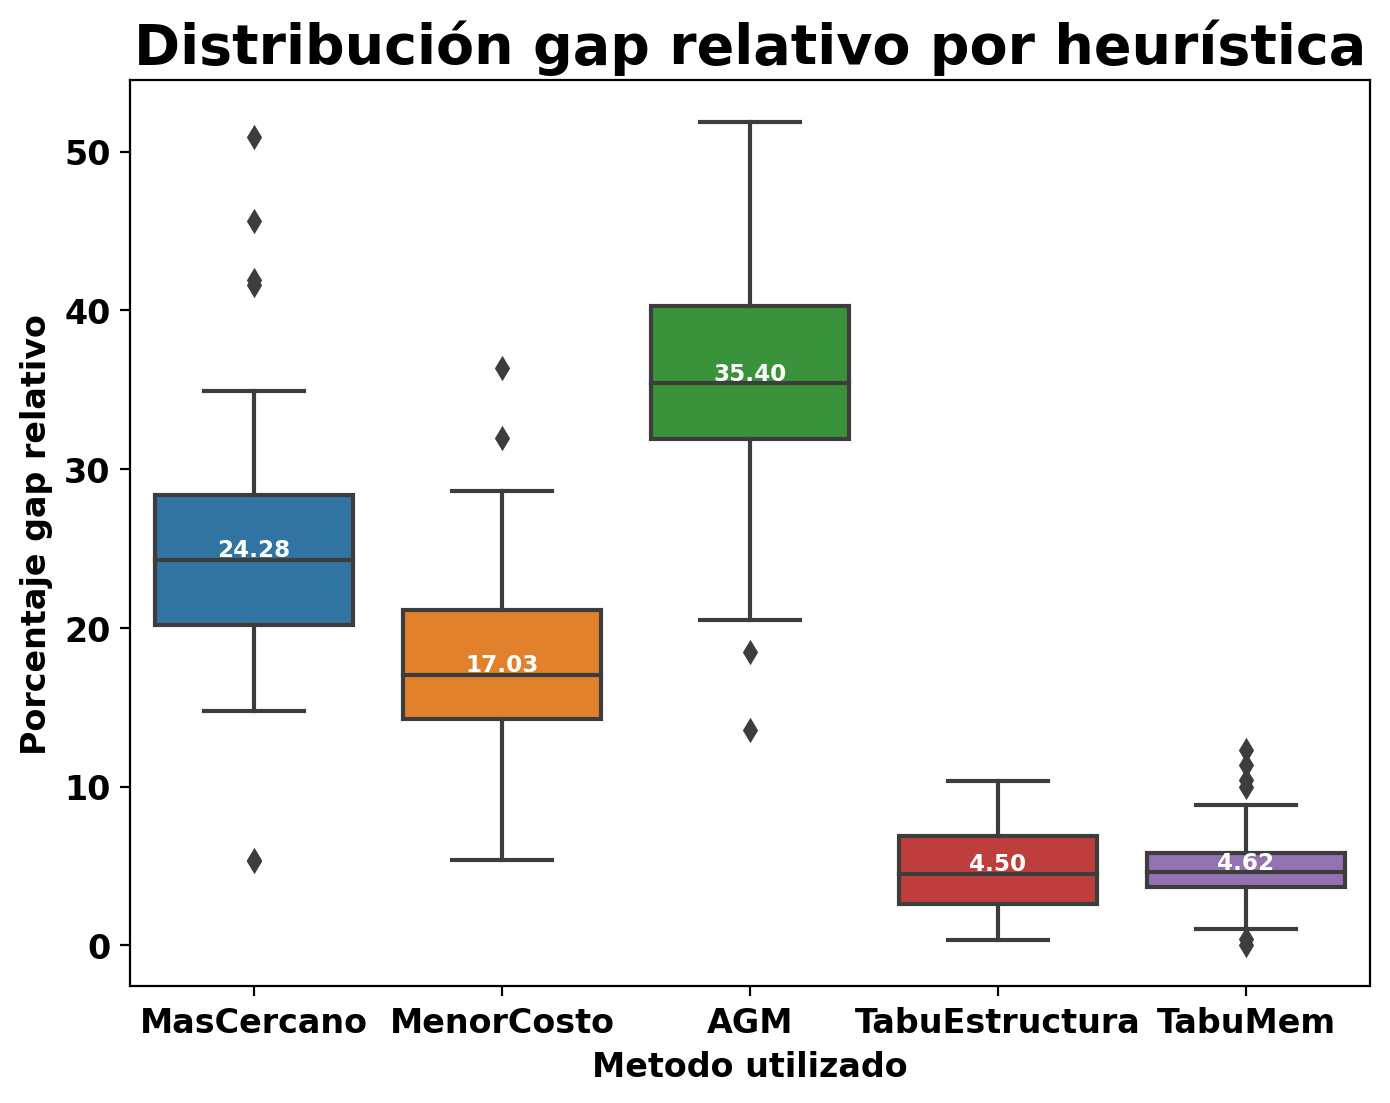

In [208]:
dfGaps = pd.DataFrame(columns=['Archivo']+METODOS)

dfGaps['Archivo'] = dfMediciones['Archivo'].unique()

for metodo in METODOS:
    dfGaps[metodo] = gapsRelativosPorMetodo(dfMediciones, dfOptimos, metodo)
gapsRelativosToBoxplot(dfGaps)

dfGaps.set_index('Archivo', inplace=True)

## Scatters

In [311]:
def medicionesToXYdf(dfMediciones, x, y, dfGaps=None):
    dfOut = pd.DataFrame(columns=['Archivo','Algoritmo', x, y])
    dfOut['Archivo'] = dfMediciones['Archivo'].unique().tolist()*5
    dfOut.sort_values(by='Archivo', inplace=True, ignore_index=True)
    for index, rows in dfOut.iterrows():
        archivoActual = rows['Archivo']
        algoritmoActual = METODOS[index%5]
        rows['Algoritmo'] = algoritmoActual
        
        
        if x == 'Gap':
            rows[x] = dfGaps.loc[archivoActual][algoritmoActual]
        else:
            rows[x] = int(dfMediciones[(dfMediciones['Archivo'] == archivoActual) & (dfMediciones['Tipo']==x)][algoritmoActual].tolist()[0])
            
        if y == 'Gap':
            rows[y] = dfGaps.loc[archivoActual][algoritmoActual]
        else:
            rows[y] = int(dfMediciones[(dfMediciones['Archivo'] == archivoActual) & (dfMediciones['Tipo']==y)][algoritmoActual].tolist()[0])
    
    return dfOut

In [299]:
def dfToScatter(dfMediciones, dfGaps, x, y, hue, title, save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    
    
    
    #Sacamos el df que necesitamos y si usa tiempo lo cambiamos a ms
    dfIn = medicionesToXYdf(dfMediciones, x, y, dfGaps)
    
    if x == 'Tiempo' or y == 'Tiempo':
        dfIn.rename(columns={'Tiempo': 'Tiempo en ms'}, inplace=True)
        dfIn['Tiempo en ms'] = dfIn['Tiempo en ms'].to_numpy(dtype=int)/1000   
        x = x if x != 'Tiempo' else 'Tiempo en ms'
        y = y if y != 'Tiempo' else 'Tiempo en ms'

    #Graficamos scatter
    sns.scatterplot(data=dfIn.reset_index(), x=x, y=y, hue=hue)
    
    #Seteamos titulo y labels
    plt.title(title, fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel(x, fontsize =LABELSIZE)
    plt.ylabel(y, fontsize =LABELSIZE)
    
    if save and out != '':
        plt.savefig(out)
    
    plt.show()

### Tiempo en funcion de cantNodos

<Figure size 432x288 with 0 Axes>

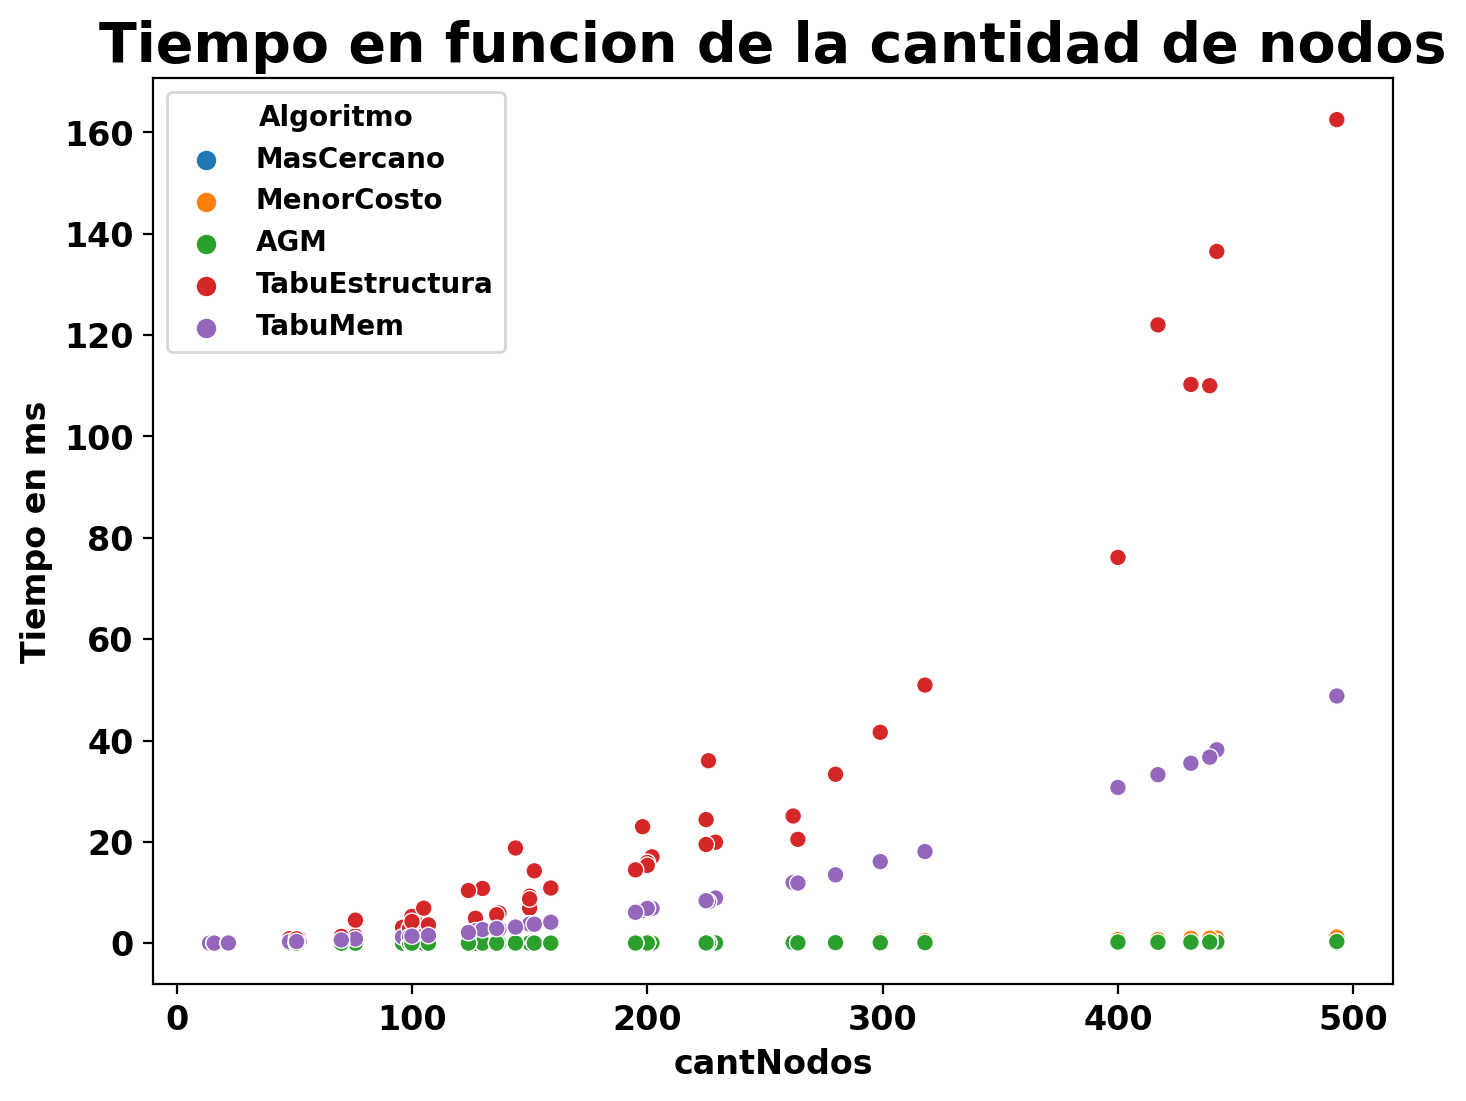

In [300]:
dfToScatter(dfMediciones, dfGaps, 'cantNodos', 'Tiempo', 'Algoritmo', 'Tiempo en funcion de la cantidad de nodos')

### Gap en funcion del Tiempo

<Figure size 432x288 with 0 Axes>

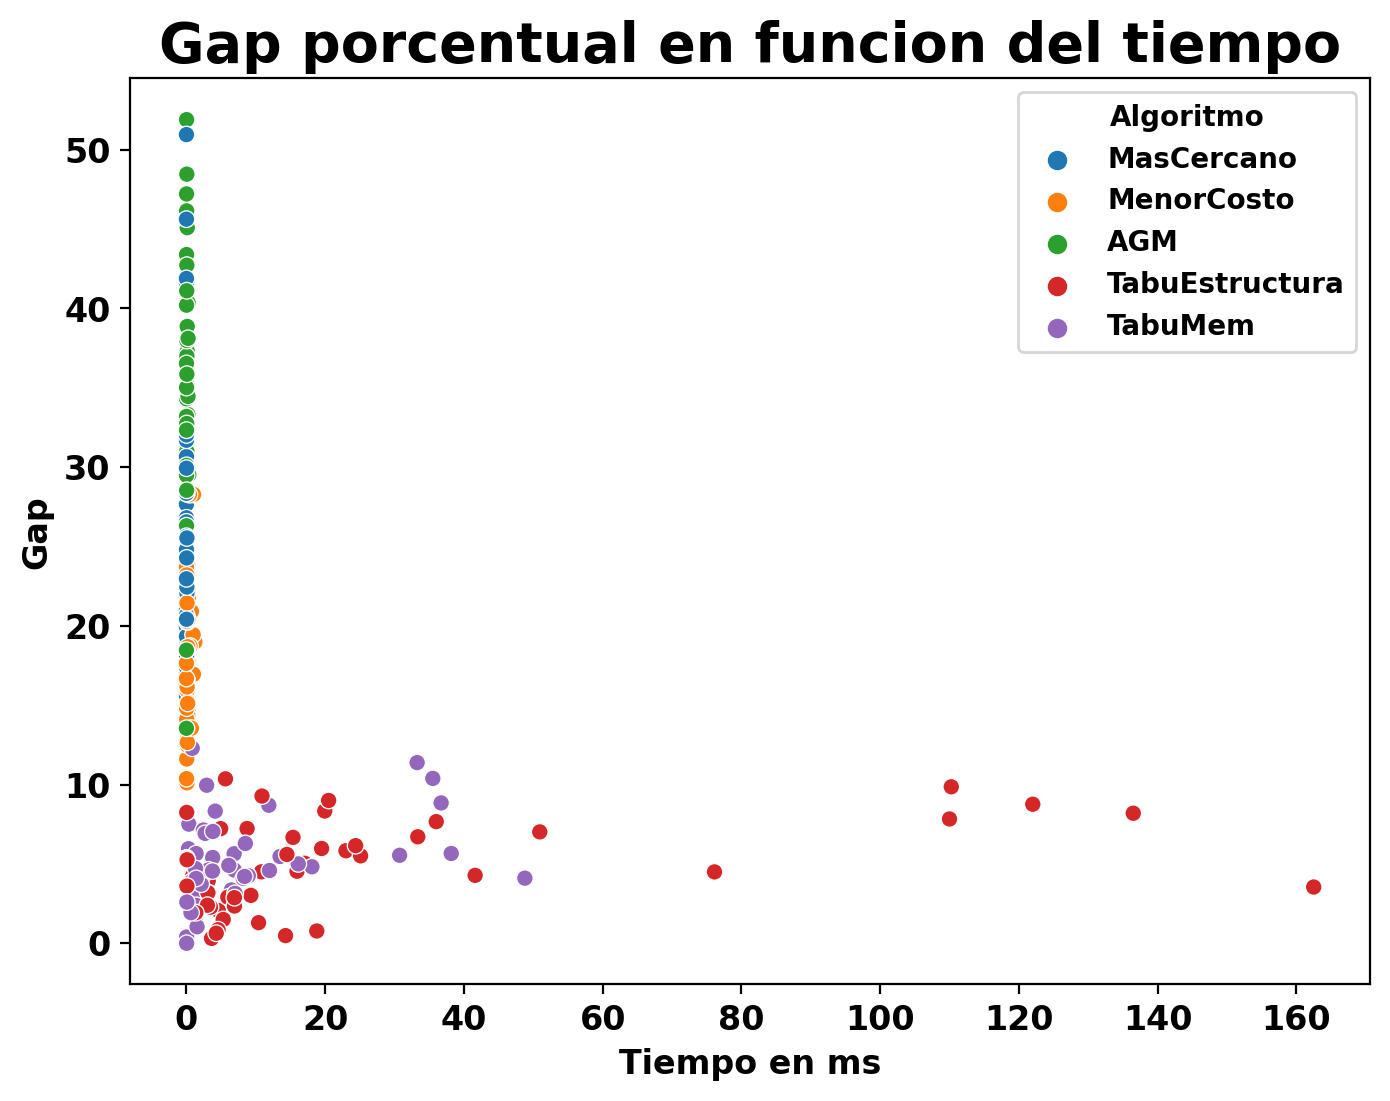

In [303]:
dfToScatter(dfMediciones, dfGaps, 'Tiempo', 'Gap', 'Algoritmo', 'Gap porcentual en funcion del tiempo')

### Armamos sets patologicos

In [717]:
def armarPatologico(cantNodos, pesoUltima, path):
    #Camino es 0,1,2,...,cantNodos-1
    cantAristas = cantNodos*(cantNodos-1)//2
    file = open(path, 'w+')
    file.write(str(cantNodos)+' '+str(cantAristas)+'\n')
    
    x = 1
    y = 5
    
    for i in range(cantNodos):
        for j in range(i+1, cantNodos):
            file.write(str(i)+" "+str(j)+" ")
            
            #Si estoy en la ultima arista
            if i == 0 and j == cantNodos-1:
                file.write(str(pesoUltima)+"\n")
                continue
            #Si estoy en el camino optimo
            if j == i+1:
                file.write(str(x)+"\n")
                continue
            #Cualquier otro
            file.write(str(y)+"\n")
    file.close()
    
def armarPatologicos(cantNodos, low, high, path):
    for i in range(low, high):
        armarPatologico(cantNodos, i, os.path.join(path,str(i)+'Costo.txt'))

In [718]:
armarPatologicos(20, 10,100, 'patologicos/')

### Graficos patologicos

### Se viene tabu

In [745]:
def appendPathToPandasTabu(path, originalDF):
    name = getNameFromPath(path)
    df = pd.read_csv(path)
    df['Archivo'] = [name]*len(df)
    originalDF = originalDF.append(df, ignore_index= True)
    return originalDF

def pathToPandasTabu(path, extension):
    originalDF = pd.DataFrame()
    files = [os.path.join(path,file) for file in os.listdir(path)]
    for file in files:
        
        if os.path.isdir(file):
            originalDF = originalDF.append(pathToPandasTabu(file, extension), ignore_index=True)
            continue
            
        #Si es un archivo y no es un .extension no me interesa y paso a la que viene
        if not getExtensionFromPath(file) == extension:
            continue
        
        if os.path.isfile(file):
            originalDF = appendPathToPandasTabu(file, originalDF)
            continue
        
        
        print("\n\nQue cosa me pasaste bro????\n\n")
        return
    
    return originalDF

def addGap(dfMem, dfOptimos):
    dfMem['Gap porcentual'] = np.nan
    for index, rows in tqdm(dfMem.iterrows()):
        archivo = rows['Archivo']
        
        if not dfOptimos.loc[archivo]['Conocida']:
            continue
        dfMem.at[index, 'Gap porcentual'] = np.round(gapRelativo(int(dfOptimos.loc[archivo]['CotaInferior']), int(rows['Peso'])), 2)
    
    return dfMem

In [744]:
dfMem

Peso  PorcentajeVecindad  TamanioMemoria  Iteracion  Tiempo  \
0      62136                   5             100          0     134   
1      61774                   5             100          1     227   
2      60531                   5             100          2     312   
3      60531                   5             100          3     397   
4      60431                   5             100          4     485   
...      ...                 ...             ...        ...     ...   
79995   7090                  25            1000        995  306294   
79996   7238                  25            1000        996  306810   
79997   7180                  25            1000        997  307652   
79998   7091                  25            1000        998  308003   
79999   7091                  25            1000        999  308593   

         Archivo    Gap  Tiempo en mseg  
0           gr96  12.55           0.134  
1           gr96  11.89           0.227  
2           gr96   9.64           0.312  
3           gr96   9.64           0.397  
4           gr96   9.46           0.485  
...          ...    ...             ...  
79995  ulysses16   3.37         306.294  
79996  ulysses16   5.53         306.810  
79997  ulysses16   4.68         307.652  
79998  ulysses16   3.38         308.003  
79999  ulysses16   3.38         308.593  

[80000 rows x 8 columns]

In [746]:
dfMem = pathToPandasTabu('DataExperimentos/GEO/', 'mem')
dfMem = addGap(dfMem, dfOptimos)
dfMem['Tiempo en mseg'] = dfMem['Tiempo']/1000
# dfMem.to_csv('everyTabuMem.csv', index=False)

80000it [00:25, 3127.99it/s]


In [733]:
def vecindadesLine(df, Y, archivo='', save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    

    if archivo == '':
        sns.lineplot(data=df[(df['TamanioMemoria'] == 100) & (df['PorcentajeVecindad'] != 15)].groupby(['PorcentajeVecindad', 'Iteracion']).mean(), x='Iteracion', y=Y, hue='PorcentajeVecindad', palette='tab10')    
    else:
        sns.lineplot(data=df[(df['TamanioMemoria'] == 100) & (df['PorcentajeVecindad'] != 15) & (df['Archivo'] == archivo)].groupby(['PorcentajeVecindad', 'Iteracion']).mean(), x='Iteracion', y=Y, hue='PorcentajeVecindad', palette='tab10')    
        
    
    #Seteamos titulo y labels
    plt.title(Y+' en función de las iteraciones\npara distinos porcentajes de vecindad', fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel('Iteración', fontsize =LABELSIZE)
    plt.ylabel(Y, fontsize =LABELSIZE)
    
    if save and out != '':
        plt.savefig(out)
    
    plt.show()

<Figure size 432x288 with 0 Axes>

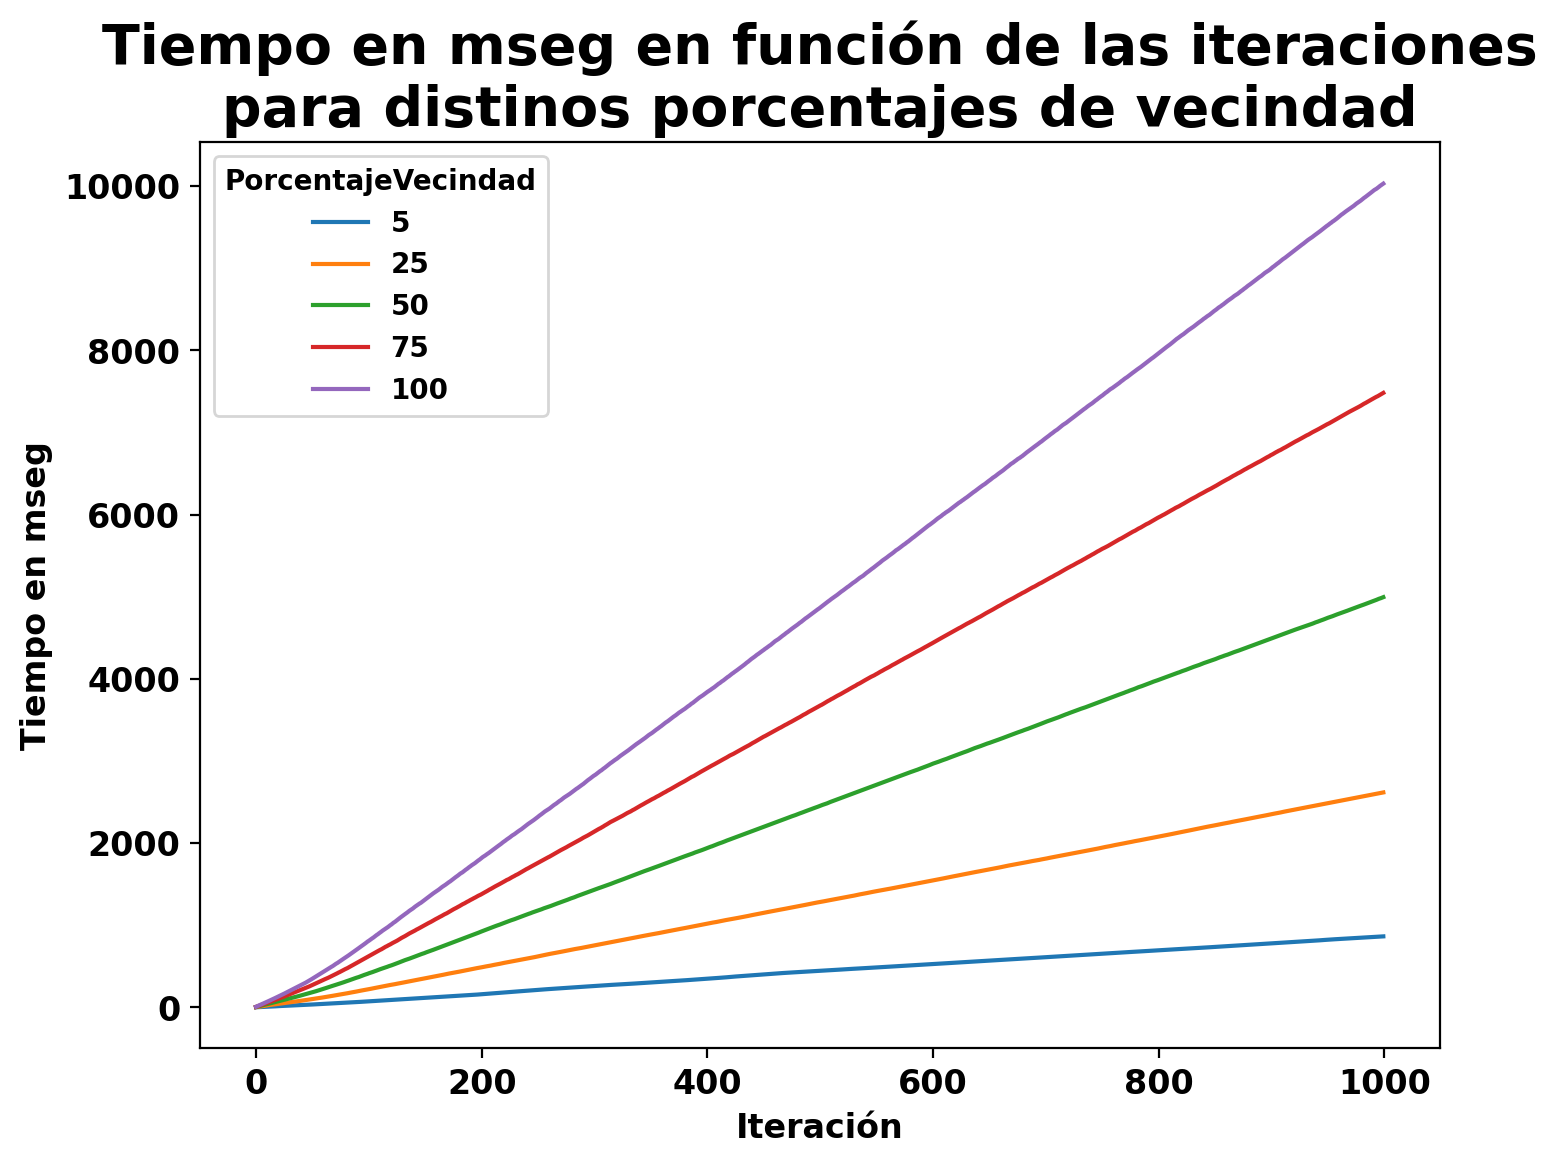

In [747]:
vecindadesLine(dfMem, 'Tiempo en mseg')

<Figure size 432x288 with 0 Axes>

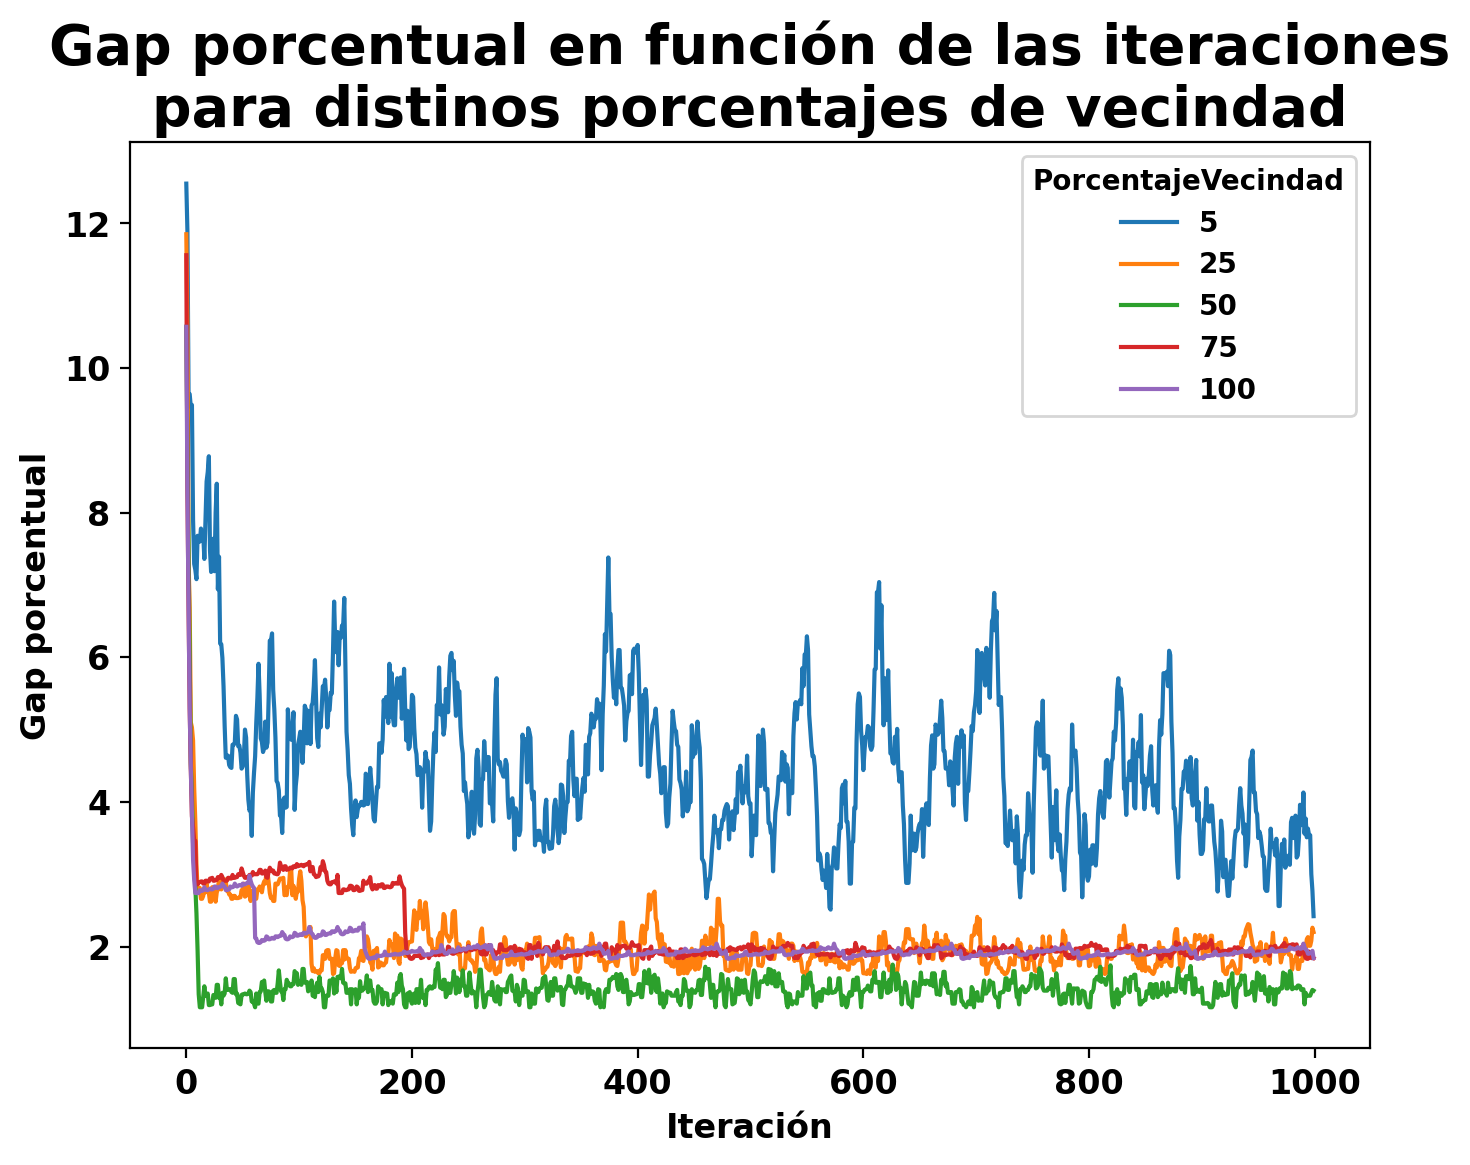

In [752]:
vecindadesLine(dfMem, 'Gap porcentual', archivo='gr96')

In [753]:
dfMem['TamanioMemoria'].unique()

array([ 100,   10,   50,  500, 1000])

In [640]:
dfMem[dfMem['PorcentajeVecindad'] == 5]

Peso  PorcentajeVecindad  TamanioMemoria  Iteracion  Tiempo  \
0      62136                   5             100          0     134   
1      61774                   5             100          1     227   
2      60531                   5             100          2     312   
3      60531                   5             100          3     397   
4      60431                   5             100          4     485   
...      ...                 ...             ...        ...     ...   
70995   8204                   5             100        995   29987   
70996   8284                   5             100        996   30012   
70997   8096                   5             100        997   30029   
70998   8058                   5             100        998   30079   
70999   8373                   5             100        999   30105   

         Archivo    Gap  
0           gr96  12.55  
1           gr96  11.89  
2           gr96   9.64  
3           gr96   9.64  
4           gr96   9.46  
...          ...    ...  
70995  ulysses16  19.61  
70996  ulysses16  20.78  
70997  ulysses16  18.03  
70998  ulysses16  17.48  
70999  ulysses16  22.07  

[8000 rows x 7 columns]

In [569]:
dfEst = pathToPandasTabu('DataExperimentos/GEO/', 'est')
dfEst = addGap(dfEst, dfOptimos)
dfEst.to_csv('everyTabuEst.csv', index=False)

80000it [00:23, 3440.60it/s]


<Figure size 432x288 with 0 Axes>

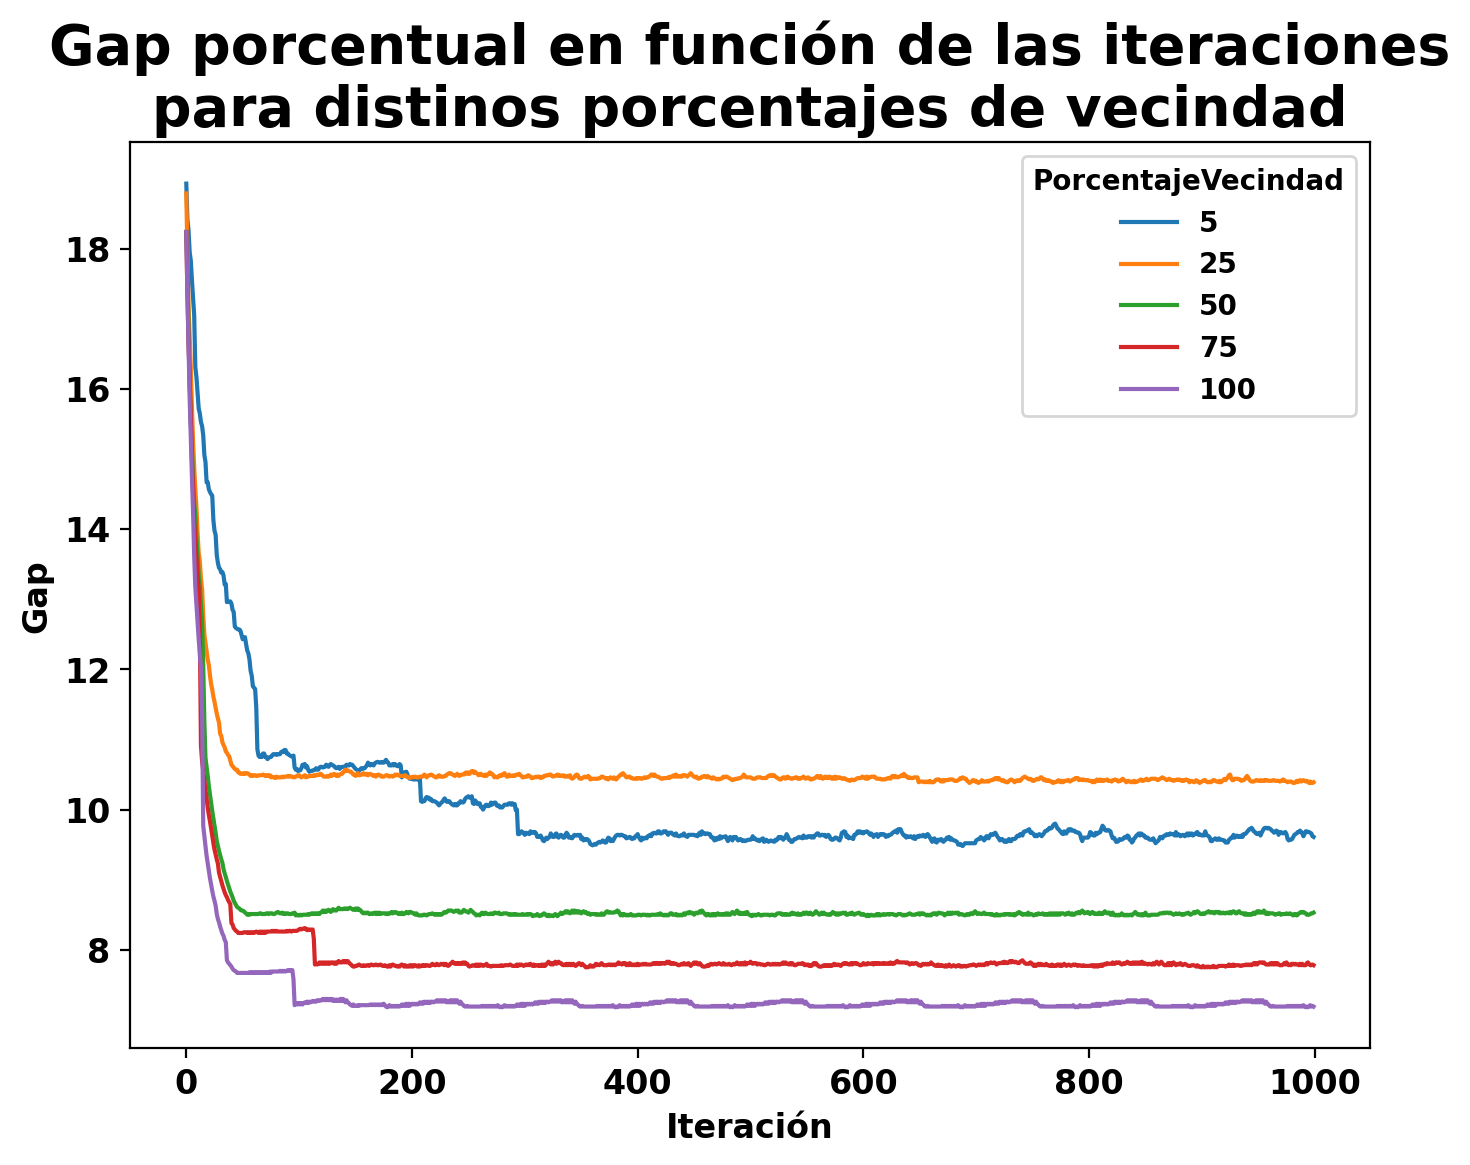

In [641]:
vecindadesScatter(dfEst)

In [ ]:
dfMem = pathToPandasTabu('DataTraining/', 'mem')
dfMem = addGap(dfMem, dfOptimos)
dfMem['Tiempo en mseg'] = dfMem['Tiempo']/1000

## Funciones a correr

In [39]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [40]:
def gapRelativo(optimo, mediocre):
    '''
    Toma primero optimo y despues mediocre
    '''
    return (mediocre-optimo)*100/optimo

def getExtensionFromPath(path):
    return path[path.rfind(".")+1:]

def getNameFromPath(path):
    return path[path.rfind("/")+1: path.find(".")]

def optimosToDF(pathOptimos):
    dfOpt = pd.read_csv(pathOptimos).set_index('Archivo')
    dfOpt['Conocida'] = np.where(dfOpt['CotaInferior'] == dfOpt['CotaSuperior'], True, False)
    
 
    return dfOpt

In [41]:
def appendPathToPandasTabu(path, originalDF):
    name = getNameFromPath(path)
    df = pd.read_csv(path)
    df['Archivo'] = [name]*len(df)
    originalDF = originalDF.append(df, ignore_index= True)
    return originalDF

def pathToPandasTabu(path, extension):
    originalDF = pd.DataFrame()
    files = [os.path.join(path,file) for file in os.listdir(path)]
    for file in files:
        
        if os.path.isdir(file):
            originalDF = originalDF.append(pathToPandasTabu(file, extension), ignore_index=True)
            continue
            
        #Si es un archivo y no es un .extension no me interesa y paso a la que viene
        if not getExtensionFromPath(file) == extension:
            continue
        
        if os.path.isfile(file):
            originalDF = appendPathToPandasTabu(file, originalDF)
            continue
        
        
        print("\n\nQue cosa me pasaste bro????\n\n")
        return
    
    return originalDF

def addGap(dfMem, dfOptimos):
    dfMem['Gap porcentual'] = np.nan
    for index, rows in tqdm(dfMem.iterrows()):
        archivo = rows['Archivo']
        
        if not dfOptimos.loc[archivo]['Conocida']:
            continue
        dfMem.at[index, 'Gap porcentual'] = np.round(gapRelativo(int(dfOptimos.loc[archivo]['CotaInferior']), int(rows['Peso'])), 2)
    
    return dfMem

In [42]:
def vecindadesLine(df, Y, archivo='', save=False, out='', algoritmo='---'):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    

    if archivo == '':
        sns.lineplot(data=df.groupby(['Iteracion']).mean(), x='Iteracion', y=Y, palette='tab10')    
    else:
        sns.lineplot(data=df[df['Archivo'] == archivo].reset_index().groupby(['Iteracion']).mean().reset_index(), x='Iteracion', y=Y, palette='tab10')    
        
    
    #Seteamos titulo y labels
    plt.title(Y+f' en función de las iteraciones\npara dataset {archivo} con tabú por {algoritmo}', fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel('Iteración', fontsize =LABELSIZE)
    plt.ylabel(Y, fontsize =LABELSIZE)
    
    if save and out != '':
        plt.savefig(out)
        return
    plt.show()

### Nos llega el DF y hacemos GAP vs Iteraciones mem=1000, %vecinos = 100

In [8]:
dfOptimos = optimosToDF("optimos.txt")

In [9]:
dfMem = pathToPandasTabu('DataTrainingOut/', 'mem')
dfMem = addGap(dfMem, dfOptimos)
dfEst = pathToPandasTabu('DataTrainingOut/', 'est')
dfEst = addGap(dfEst, dfOptimos)

35000it [00:14, 2344.57it/s]
35000it [00:14, 2478.49it/s]


In [27]:
dfMem['Archivo'].unique()

array(['gr96', 'gr202', 'gr229', 'ulysses16', 'kroB100', 'pr136',
       'kroC100', 'eil51', 'ch130', 'pcb442', 'ch150', 'kroA150', 'u159',
       'pr226', 'eil76', 'lin318', 'berlin52', 'kroB150', 'ts225', 'a280',
       'eil101', 'rat195', 'd198', 'pr76', 'st70', 'bier127', 'rat99',
       'lin105', 'gil262', 'pr264', 'kroE100', 'pr152', 'kroA100',
       'pr439', 'att48'], dtype=object)

ValueError: Could not interpret input 'Iteracion'

<Figure size 432x288 with 0 Axes>

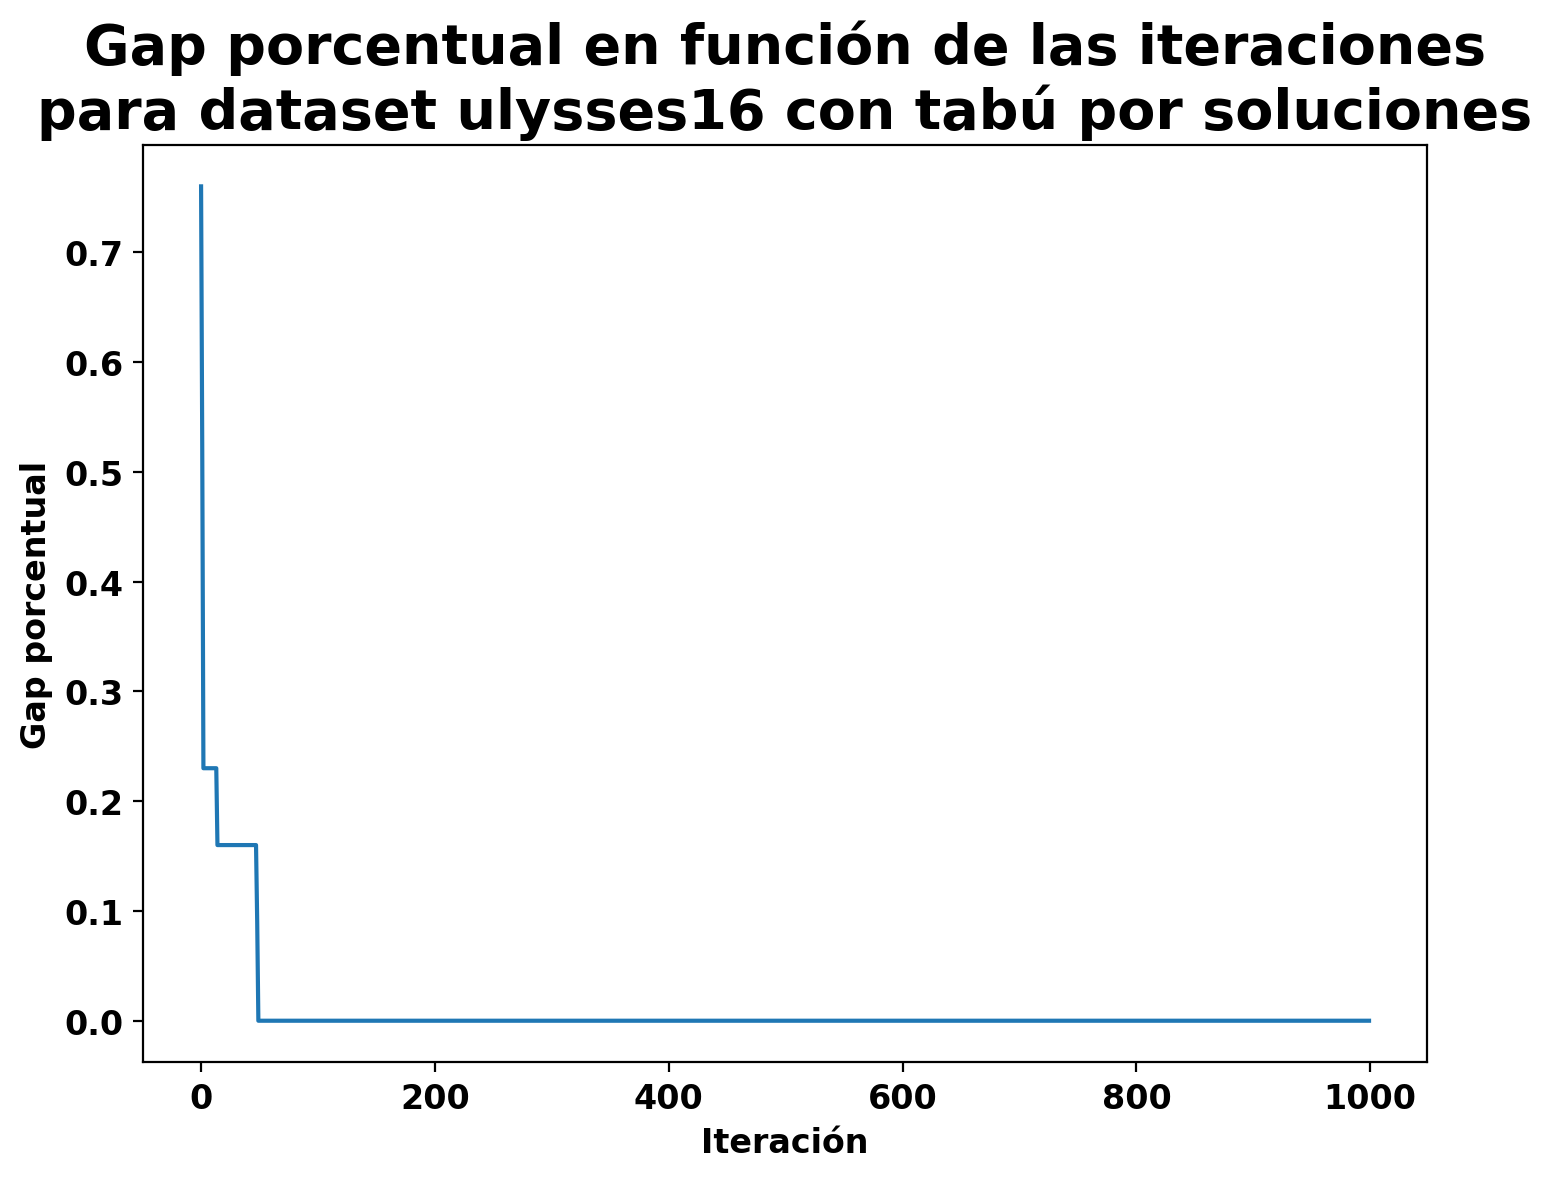

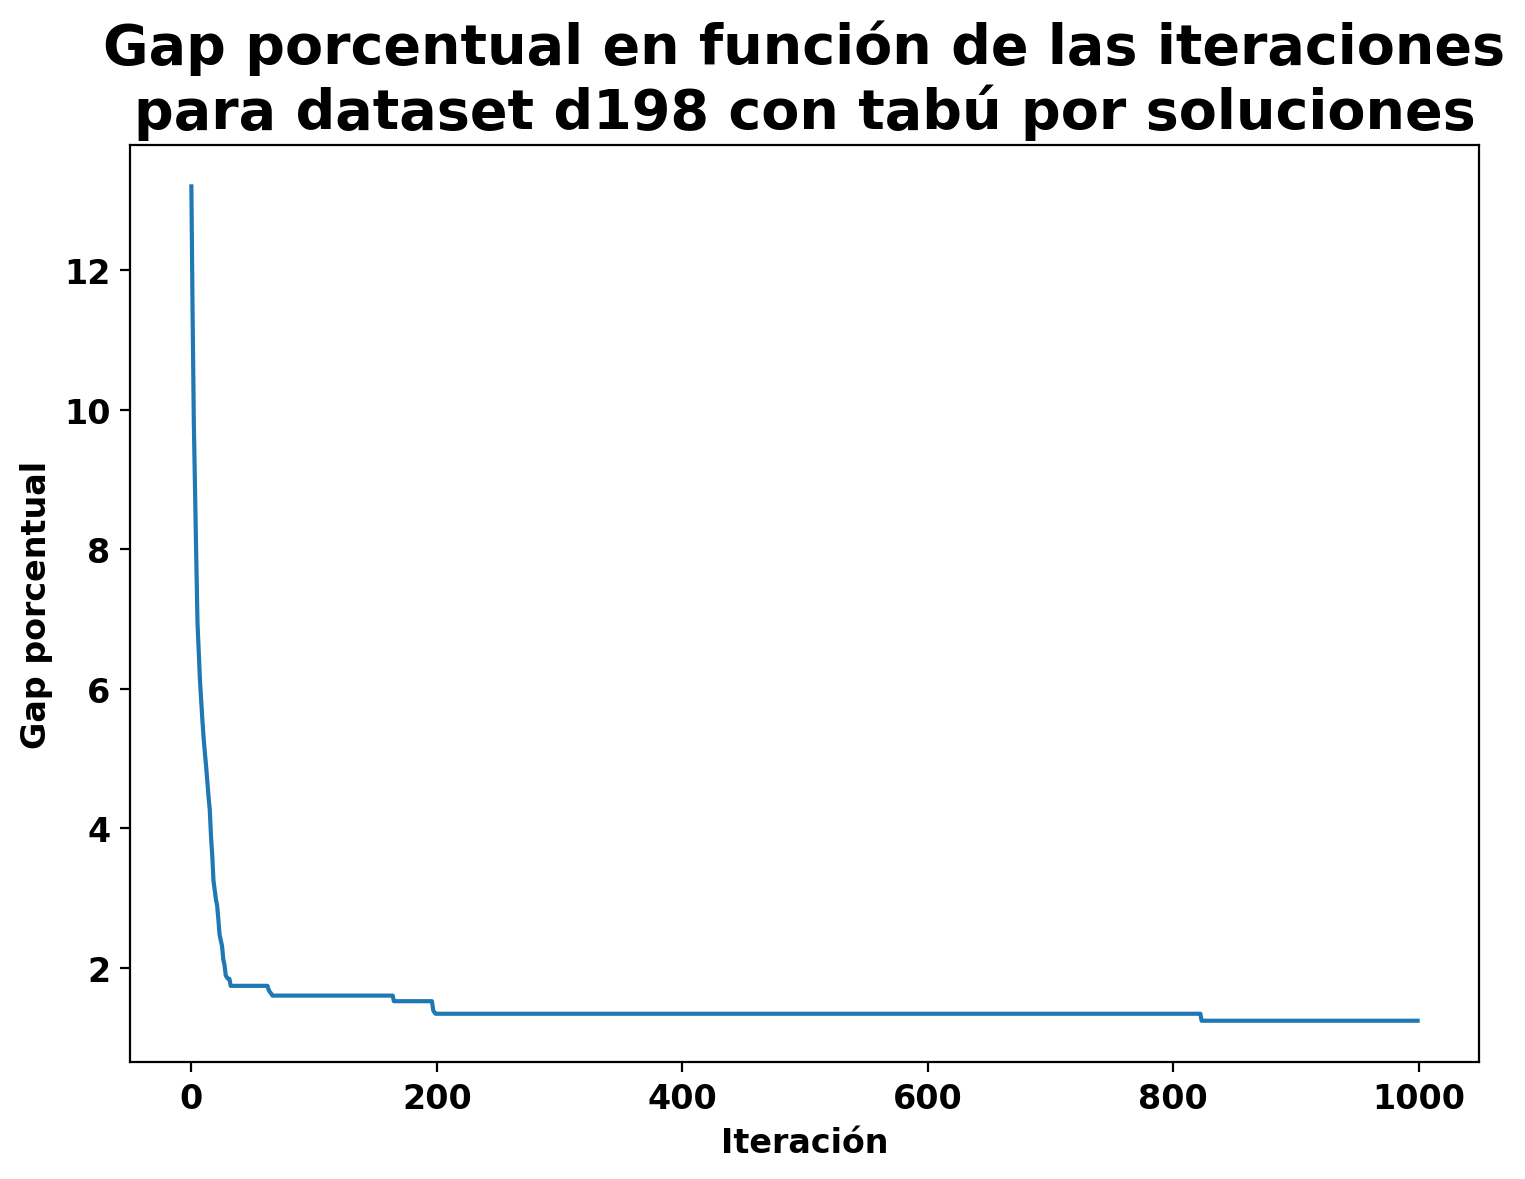

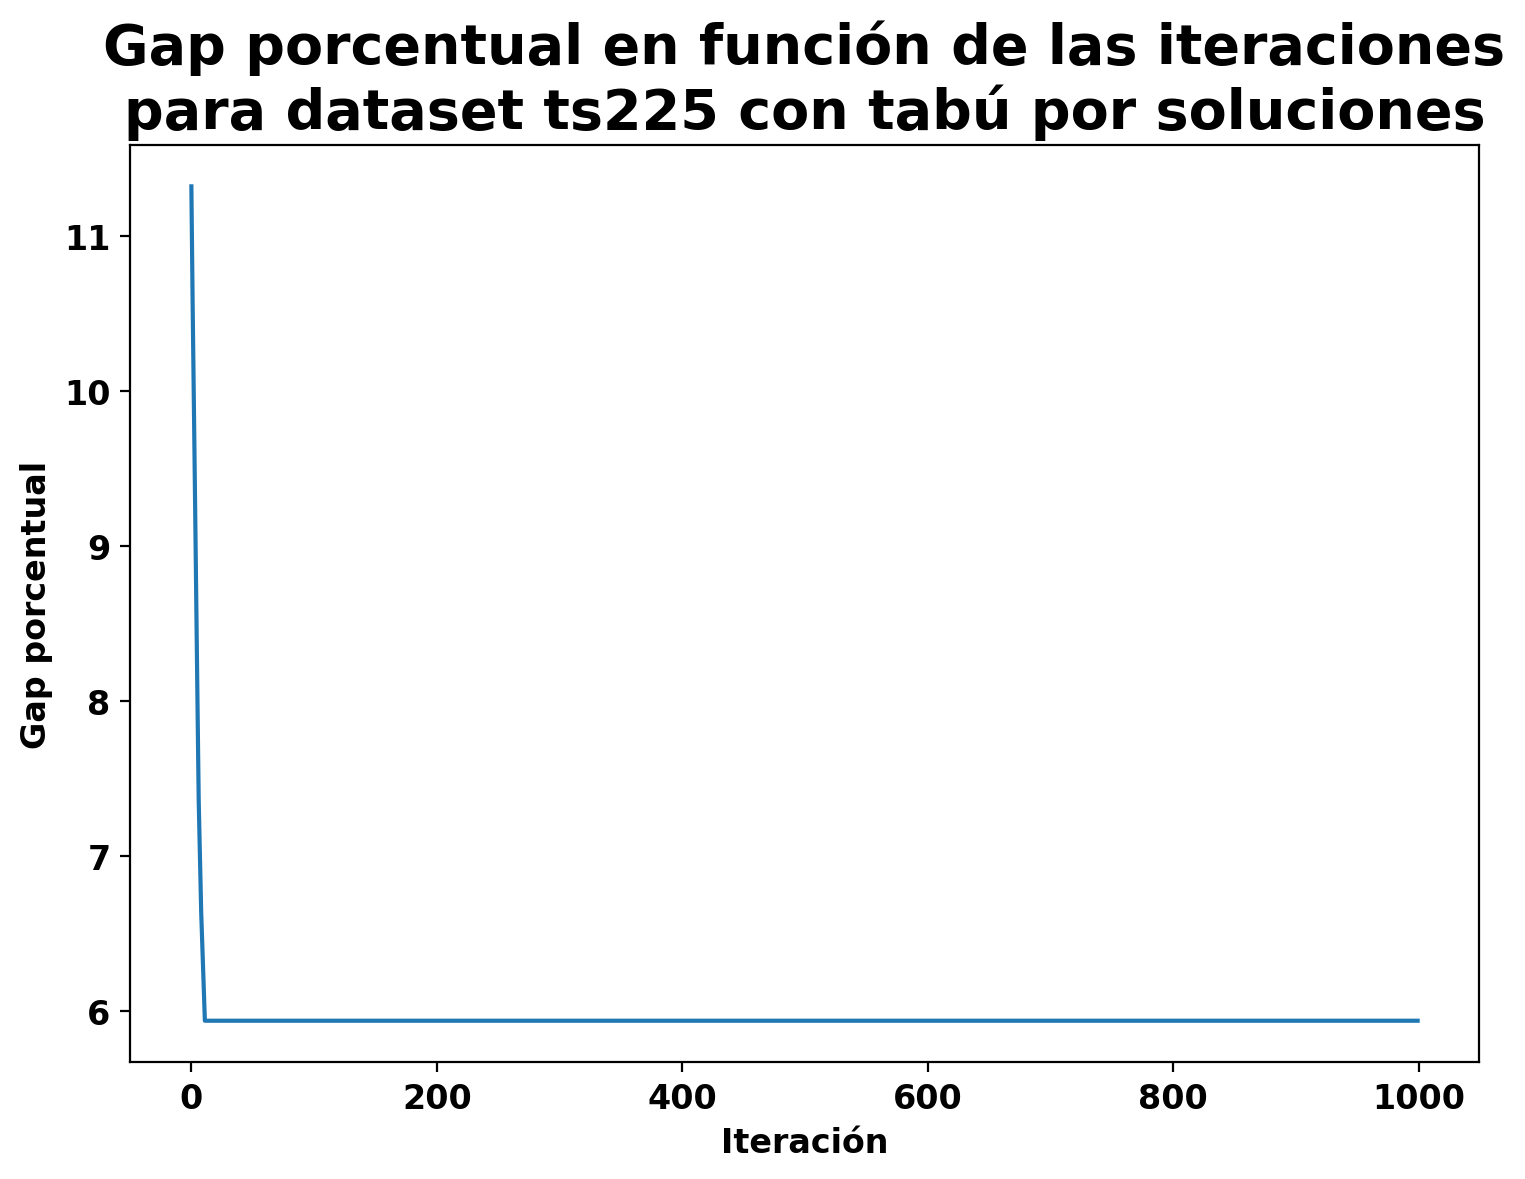

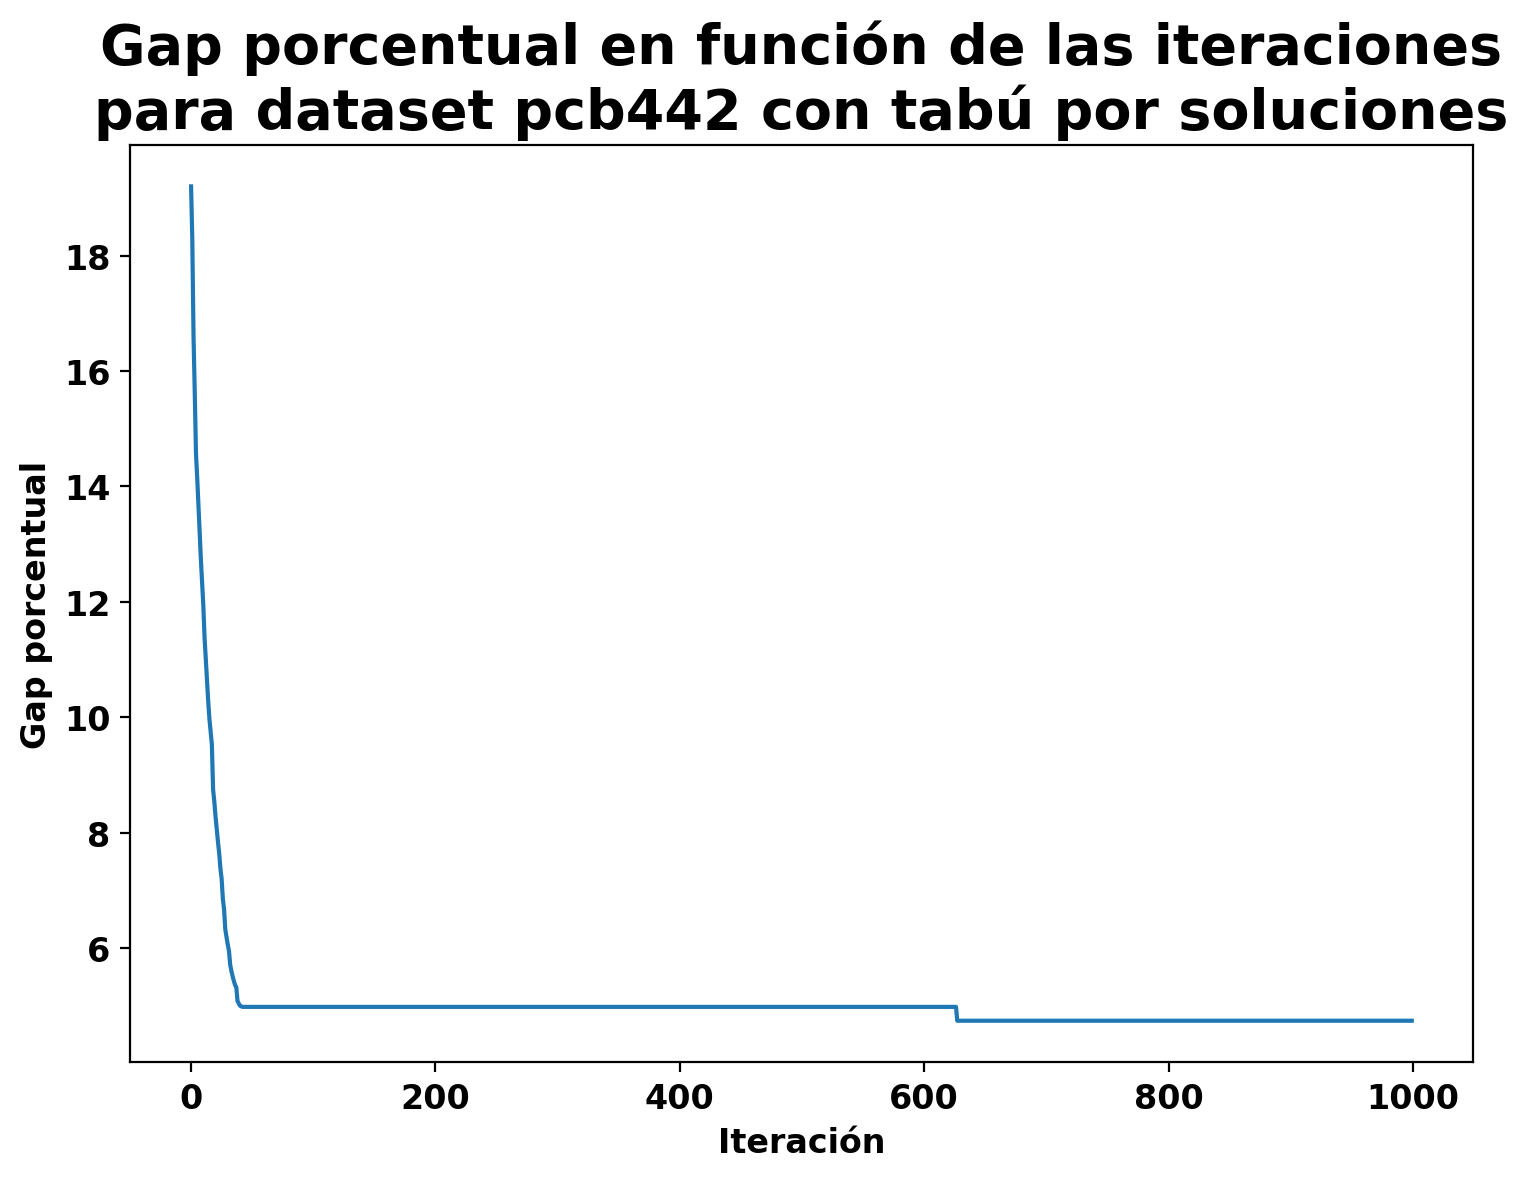

In [38]:
files = ['ulysses16', 'd198', 'ts225', 'pcb442']
for file in files:
    vecindadesLine(dfMem, 'Gap porcentual', file, True, f'graficos/GapVsIter/{file}GapVsIterMem.png', 'soluciones')  
    
for file in files:
    vecindadesLine(dfEst, 'Gap porcentual', file, True, f'graficos/GapVsIter/{file}GapVsIterEst.png', 'estructura')    

## Vamos a ver como influye variar la memoria en Tabu. Ambas veces seteamos la %vecinos en 100%.
## Empezamos graficando boxplots del GAP% vs Memoria para tabu por solucion

In [44]:
def pesoToGap(df, dfOptimos, columnas):
    
    
    for index, rows in df.iterrows():
        for columna in columnas:
            archivo = rows['Archivo']

            if not dfOptimos.loc[archivo]['Conocida']:
                continue
            df.at[index, columna] = np.round(gapRelativo(dfOptimos.loc[archivo]['CotaInferior'], df.at[index, columna]),2)
    
    return df

In [124]:
def memoriasToBoxplot(df, title, Xlabel, Ylabel, save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    
#     plt.ylim(-200,7500)
    plt.ylim(-0.5,11)
    
    #Seteamos titulo y labels
    plt.title(title, fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel(Xlabel, fontsize =LABELSIZE)
    plt.ylabel(Ylabel, fontsize =LABELSIZE)
    
    #Graficamos los BP
    bp = sns.boxplot(data=df, ax=ax)
    
    #Calculamos las medianas
    medians = df.median().tolist()
    
    for xtick in bp.get_xticks():
        bp.text(xtick,medians[xtick] + 0.1, '{:.2f}'.format(medians[xtick]), 
            horizontalalignment='center',size='small',color='w',weight='bold')

    plt.tight_layout()
    if save and out != '':
        plt.savefig(out)
    
    plt.show()

In [28]:
dfMemorias = pathToPandasTabu('DataMemoria/', 'mem').astype({"10": float, "50": float,"100": float, "500": float,"1000": float })
dfMemorias = pesoToGap(dfMemorias, dfOptimos, dfMemorias.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfMemorias.drop(['CantNodos'], axis=1), 'Distribución gap porcentual por tamaño\nde la memoria usando tabu por soluciones', 'Cantidad de memoria', 'Porcentaje de Gap relativo')

<Figure size 432x288 with 0 Axes>

## Ahora veamos como se modifica el tiempo graficando boxplots del Tiempo vs Memoria para tabu por solucion

In [39]:
dfMemoriasTiempos = pathToPandasTabu('DataMemoria/', 'timeMem').astype({"10": float, "50": float,"100": float, "500": float,"1000": float })
memoriasToBoxplot(dfMemoriasTiempos.drop(['CantNodos'], axis=1), 'Distribución del tiempo de ejecución por tamaño\nde la memoria usando tabu por soluciones', 'Cantidad de memoria', 'Tiempo en milisegundos', save=True, out='graficos/tiempoVsMem_tabuMem.png')

<Figure size 432x288 with 0 Axes>

## Chequeamos GAP% vs Memoria en tabu por estructura

In [188]:
dfEst = pathToPandasTabu('DataMemoria/', 'est').astype({"10": float, "50": float,"100": float, "500": float,"1000": float })
dfEst = pesoToGap(dfEst, dfOptimos, dfEst.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfEst.drop(['CantNodos'], axis=1), 'Distribución gap porcentual por tamaño\nde la memoria usando tabu por estructura', 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=False, out='graficos/gapVsMem_tabuEst.png')

<Figure size 432x288 with 0 Axes>

## Volvemos a ver como se afecta el tiempo graficando Tiempo vs Memoria en tabu por estructura

In [190]:
dfEstTiempos = pathToPandasTabu('DataMemoria/', 'timeEst').astype({"10": float, "50": float,"100": float, "500": float,"1000": float })
memoriasToBoxplot(dfEstTiempos.drop(['CantNodos'], axis=1), 'Distribución del tiempo de ejecución por tamaño\nde la memoria usando tabu por estructura', 'Cantidad de memoria', 'Tiempo en milisegundos', save=True, out='graficos/tiempoVsMem_tabuEst.png')

<ipython-input-124-6fe8495f367c>:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


<Figure size 432x288 with 0 Axes>

ValueError: Image size of 1567x70081 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1600x1200 with 1 Axes>

## Para elegir la memoria a usar vamos a segmentar el df anterior por tamanios a ver si para df mas grandes conviene usar mas memoria

In [193]:
dfEstChicos = dfEst.sort_values('CantNodos')[:9].reset_index().drop(['index'], axis=1)
dfEstMedioChicos = dfEst.sort_values('CantNodos')[9:17].reset_index().drop(['index'], axis=1)
dfEstMedioGrandes = dfEst.sort_values('CantNodos')[17:26].reset_index().drop(['index'], axis=1)
dfEstGrandes = dfEst.sort_values('CantNodos')[26:].reset_index().drop(['index'], axis=1)
# pesoToGap(dfEstChicos, dfOptimos, dfEstChicos.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
# pesoToGap(dfEstMedioChicos, dfOptimos, dfEstMedioChicos.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
# pesoToGap(dfEstMedioGrandes, dfOptimos, dfEstMedioGrandes.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
# pesoToGap(dfEstGrandes, dfOptimos, dfEstGrandes.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())

In [194]:
dfEstGrandes

CantNodos    10    50   100   500  1000 Archivo
0        225  5.94  5.94  5.45  5.68  5.68   ts225
1        226  3.40  2.72  2.72  2.41  2.41   pr226
2        229  3.88  3.88  2.19  2.38  2.38   gr229
3        262  4.54  4.29  4.21  4.37  4.37  gil262
4        264  5.99  4.91  4.89  5.00  5.00   pr264
5        280  4.73  2.91  2.09  2.33  2.33    a280
6        318  3.57  2.84  2.84  2.89  2.89  lin318
7        439  4.82  4.82  4.79  4.82  4.82   pr439
8        442  4.52  4.35  3.69  3.85  3.85  pcb442

In [69]:
memoriasToBoxplot(dfEstChicos.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por tamaño\nde la memoria usando tabú por soluciones\ncon instancias entre {dfEstChicos.loc[0]['CantNodos']} y {dfEstChicos.loc[len(dfEstChicos)-1]['CantNodos']} nodos", 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=True, out='graficos/GapVsMemChicos_est.png')

<Figure size 432x288 with 0 Axes>

In [70]:
memoriasToBoxplot(dfEstMedioChicos.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por tamaño\nde la memoria usando tabú por soluciones\ncon instancias entre {dfEstMedioChicos.loc[0]['CantNodos']} y {dfEstMedioChicos.loc[len(dfEstMedioChicos)-1]['CantNodos']} nodos", 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=True, out='graficos/GapVsMemMedioChicos_est.png')

<Figure size 432x288 with 0 Axes>

In [71]:
memoriasToBoxplot(dfEstMedioGrandes.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por tamaño\nde la memoria usando tabú por soluciones\ncon instancias entre {dfEstMedioGrandes.loc[0]['CantNodos']} y {dfEstMedioGrandes.loc[len(dfEstMedioGrandes)-1]['CantNodos']} nodos", 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=True, out='graficos/GapVsMemMedioGrandes_est.png')

<Figure size 432x288 with 0 Axes>

In [74]:
memoriasToBoxplot(dfEstGrandes.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por tamaño\nde la memoria usando tabú por soluciones\ncon instancias entre {dfEstGrandes.loc[0]['CantNodos']} y {dfEstGrandes.loc[len(dfEstGrandes)-1]['CantNodos']} nodos", 'Cantidad de memoria', 'Porcentaje de Gap relativo', save=True, out='graficos/GapVsMemGrandes_est.png')

<Figure size 432x288 with 0 Axes>

### Chequeo diferencias

In [86]:
dfEstChicos['Size']=['Chicos']*len(dfEstChicos)
dfEstMedioChicos['Size']=['Medio chicos']*len(dfEstMedioChicos)
dfEstMedioGrandes['Size']=["Medio grandes"]*len(dfEstMedioGrandes)
dfEstGrandes['Size']=["Grandes"]*len(dfEstGrandes)

In [88]:
dfPorTamanos=dfEstChicos.append(dfEstMedioChicos, ignore_index=True)
dfPorTamanos=dfPorTamanos.append(dfEstMedioGrandes, ignore_index=True)
dfPorTamanos=dfPorTamanos.append(dfEstGrandes, ignore_index=True)

In [115]:
sns.barplot(data=dfEstMedioChicos.drop(['CantNodos'],axis=1))
plt.ylim(0,6)

(0, 6)

(0, 6)

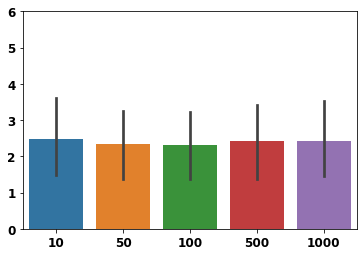

In [116]:
sns.barplot(data=dfEstMedioChicos.drop(['CantNodos'],axis=1))
plt.ylim(0,6)

In [117]:
sns.barplot(data=dfEstMedioGrandes.drop(['CantNodos'],axis=1))
plt.ylim(0,6)

(0, 6)

(0, 6)

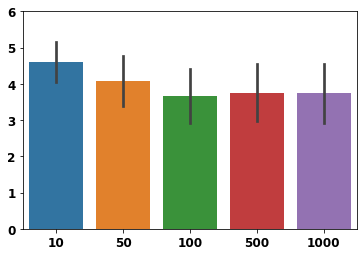

In [118]:
sns.barplot(data=dfEstGrandes.drop(['CantNodos'],axis=1))
plt.ylim(0,6)

## Como vimos que no hay un incremento considerable en el tiempo al aumentar la memoria en estructura nos vamos a quedar con memorias 500 y 1000 que son las 2 mas performantes

## En tabu por soluciones nos quedamos con 50 y 100, ya que aca si hay un aumento fulero de tiempo al aumentar la memoria.

# Ahora toca variar la vecindad

## Boxplots gaps variando porcentaje vecindad en tabu por soluciones para memoria = 50.

<Figure size 432x288 with 0 Axes>

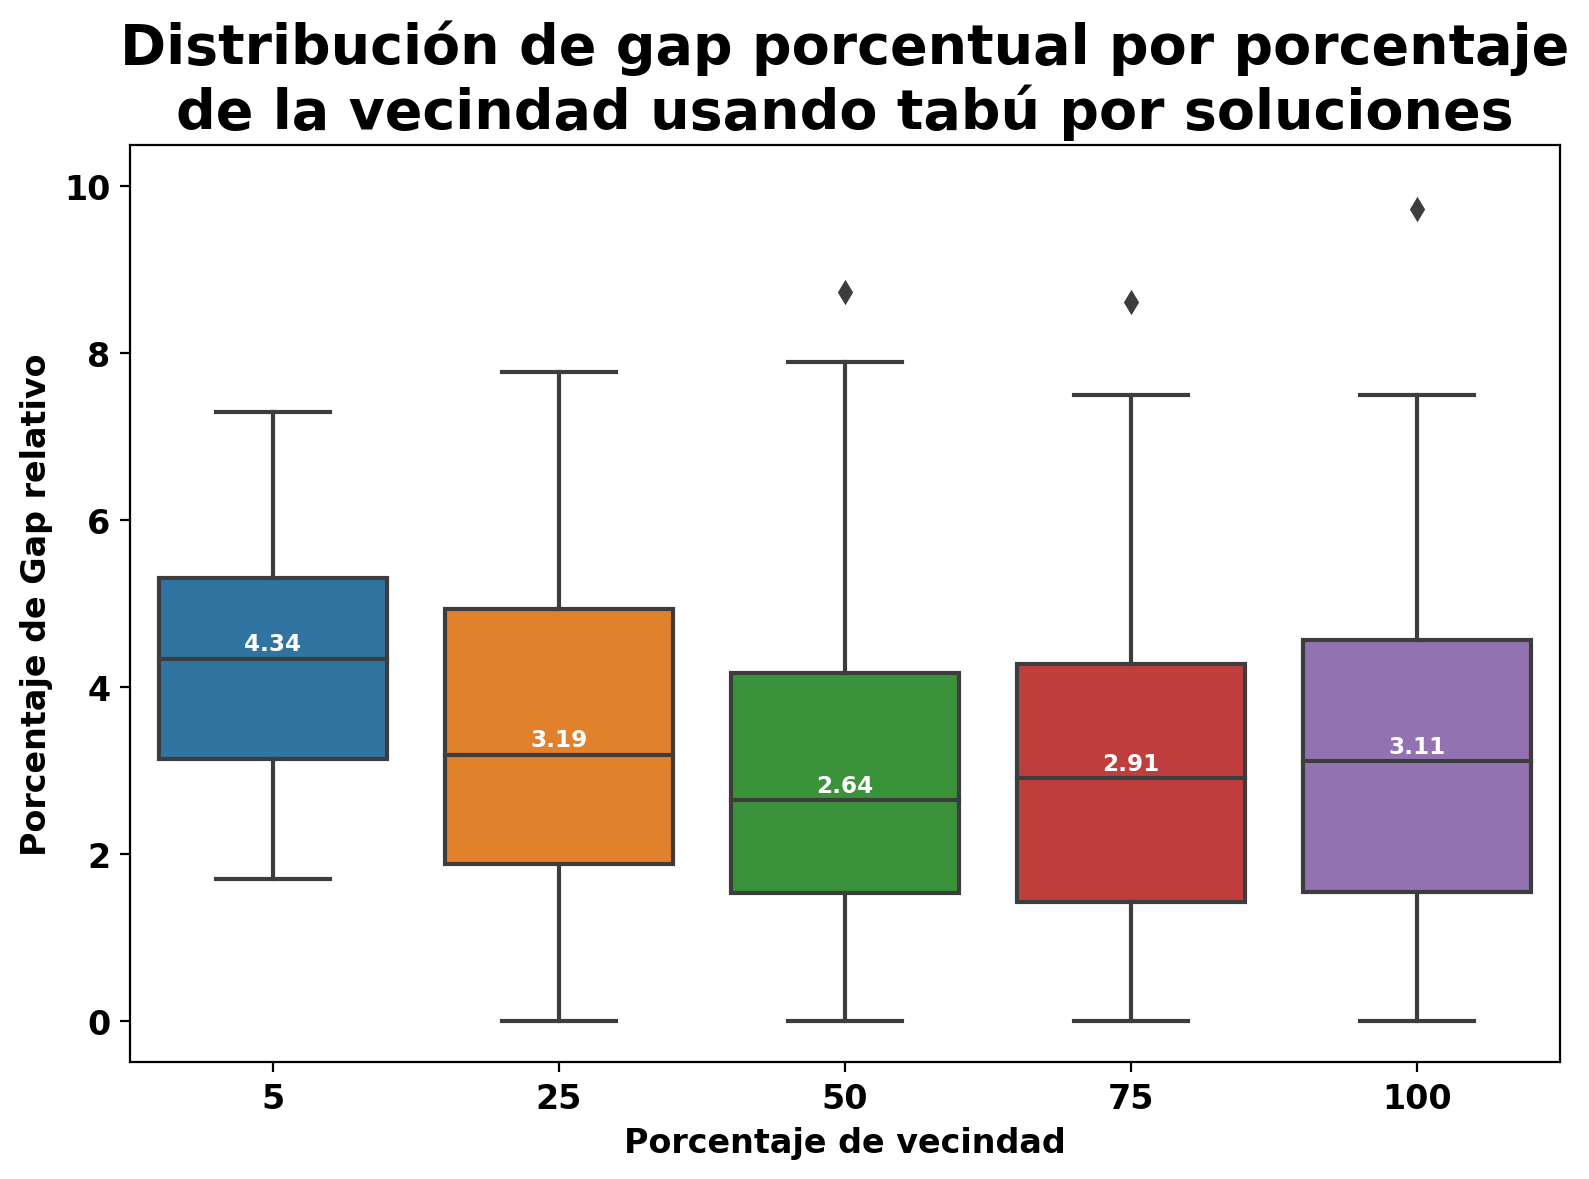

In [76]:
dfMemVecindad50 = pathToPandasTabu('DataVecindadMem50/', 'mem').astype({"5": float, "25": float,"50": float, "75": float,"100": float })
dfMemVecindad50 = pesoToGap(dfMemVecindad50, dfOptimos, dfMemVecindad50.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfMemVecindad50.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por porcentaje\nde la vecindad usando tabú por soluciones", 'Porcentaje de vecindad', 'Porcentaje de Gap relativo', save=True, out='graficos/gapVsVec_tabuMem.png')

## Ahora miramos como cambia el tiempo

In [81]:
dfMemVecindad50Tiempo = pathToPandasTabu('DataVecindadMem50/', 'timeMem').astype({"5": float, "25": float,"50": float, "75": float,"100": float })
memoriasToBoxplot(dfMemVecindad50Tiempo.drop(['CantNodos'], axis=1), f"Distribución del tiempo de ejecución por\nporcentaje de la vecindad usando\ntabú por soluciones", 'Porcentaje de vecindad', 'Tiempo en milisegundos', save=True, out='graficos/variandoVecinos/tiempoVsVec_tabuMem.png')

<Figure size 432x288 with 0 Axes>

## Hacemos lo mismo para tabu por estructura. Aca la memoria queda fija en 500.

In [84]:
dfEstVecindad500 = pathToPandasTabu('DataVecindadEst500/', 'est').astype({"5": float, "25": float,"50": float, "75": float,"100": float })
dfEstVecindad500 = pesoToGap(dfEstVecindad500, dfOptimos, dfEstVecindad500.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfEstVecindad500.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual por porcentaje\nde la vecindad usando tabú por estructura", 'Porcentaje de vecindad', 'Porcentaje de Gap relativo', save=True, out='graficos/variandoVecinos/gapVsVec_tabuEst.png')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

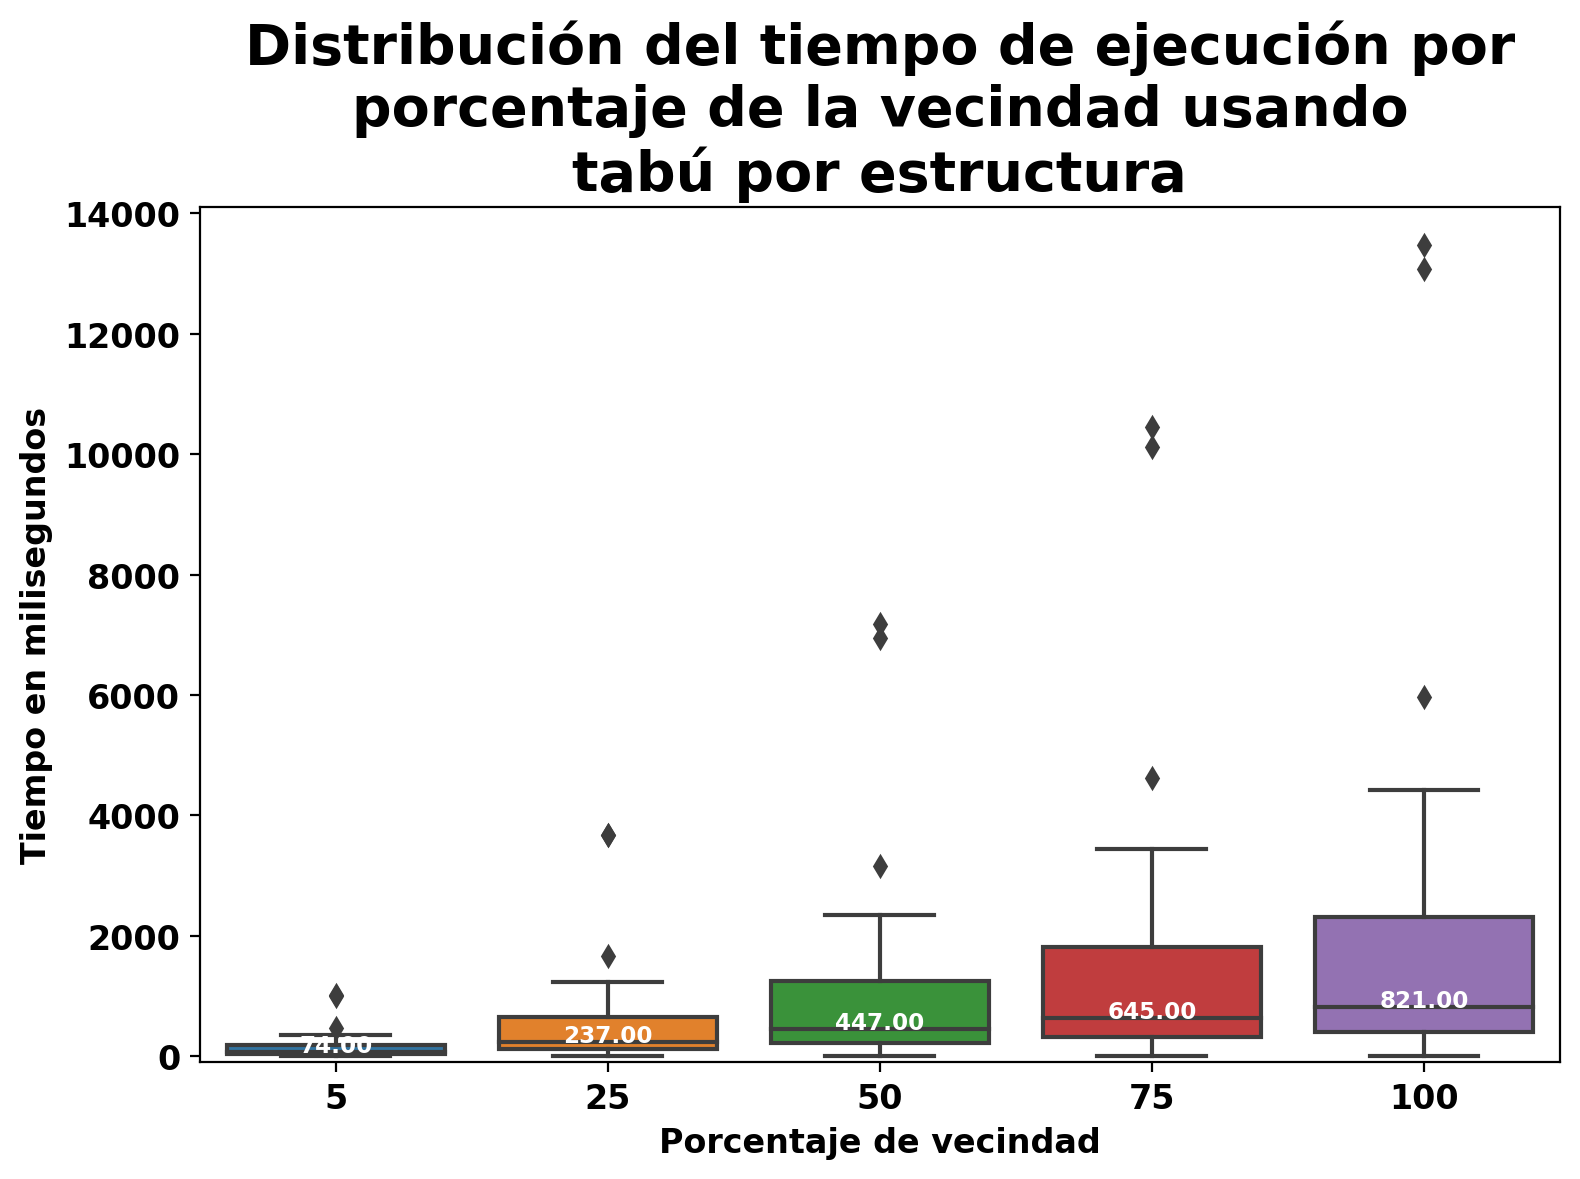

In [82]:
dfEstVecindad500Time = pathToPandasTabu('DataVecindadEst500/', 'timeEst').astype({"5": float, "25": float,"50": float, "75": float,"100": float })
memoriasToBoxplot(dfEstVecindad500Time.drop(['CantNodos'], axis=1), f"Distribución del tiempo de ejecución por\nporcentaje de la vecindad usando\ntabú por estructura", 'Porcentaje de vecindad', 'Tiempo en milisegundos', save=True, out='graficos/variandoVecinos/tiempoVsVec_tabuEst.png')

## En los 2 casos que vimos estamos viendo que parece que gana 75%. El problema es que es muy caro. Asi que decidimos quedarnos con 25% y 50% en ambos casos para CV.

## Hacemos cross validation

### Empezamos con tabu por soluciones

<Figure size 432x288 with 0 Axes>

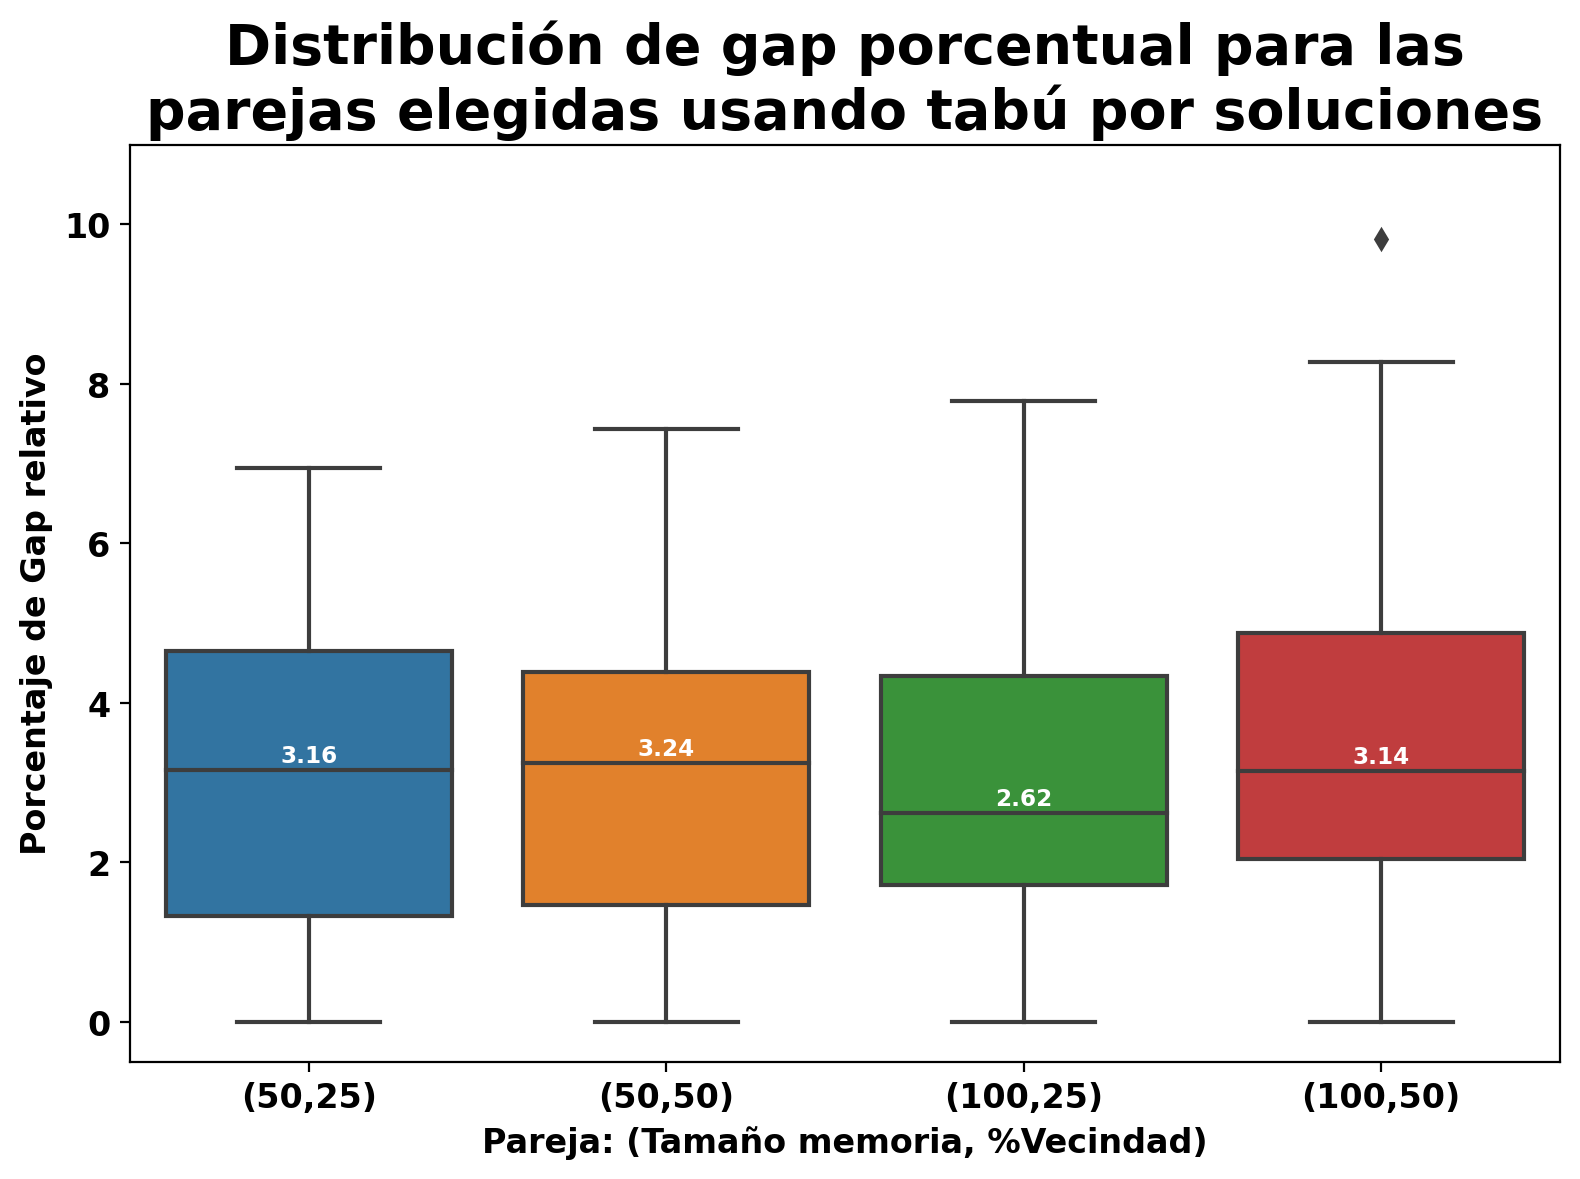

In [23]:
dfCrossMem = pathToPandasTabu('DataCross/', 'mem') \
.drop(['(100','25).1','(100.1','50).1'], axis=1)   \
.rename(columns={'(50': '(50,25)', '25)': '(50,50)','(50.1': '(100,25)','50)': '(100,50)'}) \
.astype({'(50,25)': float, '(50,50)': float,'(100,25)': float, '(100,50)': float })
dfCrossMem = pesoToGap(dfCrossMem, dfOptimos, dfCrossMem.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfCrossMem.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual para las\nparejas elegidas usando tabú por soluciones", 'Pareja: (Tamaño memoria, %Vecindad)', 'Porcentaje de Gap relativo', save=True, out='graficos/CV/gap_tabuMem.png')

In [27]:
dfCrossMemTime = pathToPandasTabu('DataCross/', 'timeMem') \
.drop(['(100','25).1','(100.1','50).1'], axis=1)   \
.rename(columns={'(50': '(50,25)', '25)': '(50,50)','(50.1': '(100,25)','50)': '(100,50)'}) \
.astype({'(50,25)': float, '(50,50)': float,'(100,25)': float, '(100,50)': float })
memoriasToBoxplot(dfCrossMemTime.drop(['CantNodos'], axis=1), f"Distribución del tiempo de ejecución para las\nparejas elegidas usando tabú por soluciones", 'Pareja: (Tamaño memoria, %Vecindad)', 'Tiempo en milisegundos', save=True, out='graficos/CV/tiempo_tabuMem.png')

<Figure size 432x288 with 0 Axes>

### Para terminar hacemos tabu por estructura

In [15]:
pathToPandasTabu('DataCross/', 'est').head()

CantNodos    (500     25)  (500.1     50)  (1000  25).1  (1000.1  50).1  \
0        202   41969   42038   41721   41792    NaN    NaN      NaN    NaN   
1         16    6859    6859    6859    6859    NaN    NaN      NaN    NaN   
2         96   56950   56762   56250   56340    NaN    NaN      NaN    NaN   
3        229  138740  143588  138176  138152    NaN    NaN      NaN    NaN   
4        280    2647    2677    2636    2643    NaN    NaN      NaN    NaN   

     Archivo  
0      gr202  
1  ulysses16  
2       gr96  
3      gr229  
4       a280

In [31]:
dfCrossEst = pathToPandasTabu('DataCross/', 'est') \
.drop(['(1000','25).1','(1000.1','50).1'], axis=1)   \
.rename(columns={'(500': '(500,25)', '25)': '(500,50)','(500.1': '(1000,25)','50)': '(1000,50)'}) \
.astype({'(500,25)': float, '(500,50)': float,'(1000,25)': float, '(1000,50)': float })
dfCrossEst = pesoToGap(dfCrossEst, dfOptimos, dfCrossEst.drop(['CantNodos', 'Archivo'], axis=1).columns.tolist())
memoriasToBoxplot(dfCrossEst.drop(['CantNodos'], axis=1), f"Distribución de gap porcentual para las\nparejas elegidas usando tabú por estructura", 'Pareja: (Tamaño memoria, %Vecindad)', 'Porcentaje de Gap relativo', save=True, out='graficos/CV/gap_tabuEst.png')

<Figure size 432x288 with 0 Axes>

In [29]:
dfCrossEstTime = pathToPandasTabu('DataCross/', 'timeEst') \
.drop(['(1000','25).1','(1000.1','50).1'], axis=1)   \
.rename(columns={'(500': '(500,25)', '25)': '(500,50)','(500.1': '(1000,25)','50)': '(1000,50)'}) \
.astype({'(500,25)': float, '(500,50)': float,'(1000,25)': float, '(1000,50)': float })
memoriasToBoxplot(dfCrossEstTime.drop(['CantNodos'], axis=1), f"Distribución del tiempo de ejecución para las\nparejas elegidas usando tabú por estructura", 'Pareja: (Tamaño memoria, %Vecindad)', 'Tiempo en milisegundos', save=True, out='graficos/CV/tiempo_tabuEst.png')

<Figure size 432x288 with 0 Axes>

### Data validacion

In [168]:
dfValEst = pathToPandasTabu('DataValidacionOut/', 'est') \
.astype({'Peso': float})
dfValEst.sort_values(['CantNodos'], inplace=True)
dfValEst = pesoToGap(dfValEst, dfOptimos, dfValEst.drop(['CantNodos', 'Archivo','TamanioMemoria','PorcentajeVecindad'], axis=1).columns.tolist())

In [169]:
dfValEst

CantNodos  TamanioMemoria  PorcentajeVecindad  Peso    Archivo
2          14             500                  50  0.00    burma14
1          22             500                  50  0.00  ulysses22
9         100             500                  50  2.78    kroD100
13        100             500                  50  2.68      rd100
12        107             500                  50  0.12      pr107
4         124             500                  50  0.88      pr124
3         137             500                  50  2.16      gr137
8         144             500                  50  0.45      pr144
5         200             500                  50  3.22    kroA200
6         200             500                  50  2.44    kroB200
14        225             500                  50  4.47     tsp225
11        299             500                  50  3.06      pr299
10        400             500                  50  3.51      rd400
7         417             500                  50  1.70      fl417
0         431             500                  50  9.38      gr431

In [180]:
def testing_results(df,title,Xlabel,Ylabel, save=False, out=''):
    LABELSIZE = 12
    TITLESIZE = 20
    
    #Seteamos tamanio y bold en todas las letras
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["ytick.labelsize"] = LABELSIZE
    plt.rcParams["xtick.labelsize"] = LABELSIZE
    plt.tight_layout()
    
    fig, ax = plt.subplots(dpi=200, figsize=(8,6))
    
    #Graficamos los pesos
    sns.barplot(data=df, x='Archivo', y='Peso',palette=sns.color_palette("hls", 8))
    
    #Graficamos el promedio
    plt.hlines(df['Peso'].mean(), xmin=-1, xmax=len(df), label='Promedio Gap')
    
    #Seteamos titulo y labels
    plt.title(title, fontweight="bold", fontsize = TITLESIZE)
    plt.xlabel(Xlabel, fontsize =LABELSIZE)
    plt.ylabel(Ylabel, fontsize =LABELSIZE)
   
    plt.xticks(rotation=90)  
    plt.legend()

    plt.tight_layout()
    if save and out != '':
        plt.savefig(out)
    
    plt.show()

<Figure size 432x288 with 0 Axes>

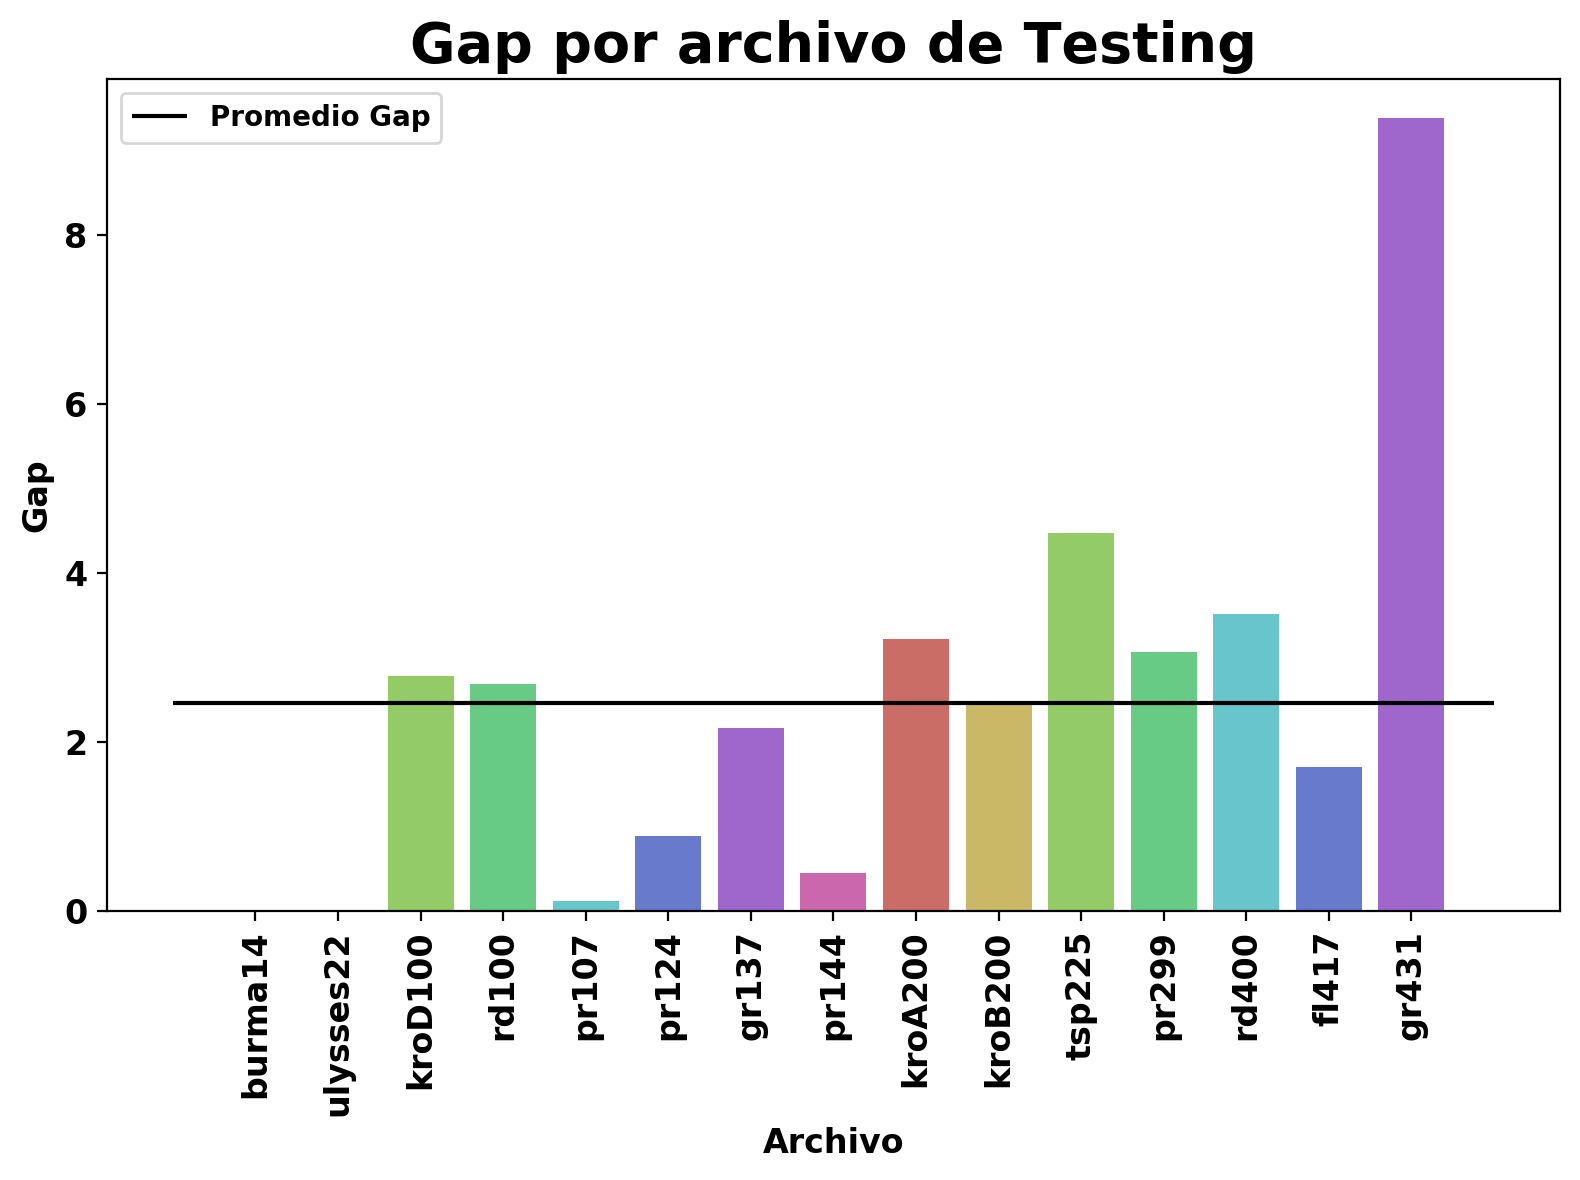

In [181]:
testing_results(dfValEst, 'Gap por archivo de Testing','Archivo', 'Gap', True, 'graficos/resultadosValidacion.png')